#Importing


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from timeit import default_timer as timers
import pickle
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, r2_score


<ipython-input-25-7131fa4b9850>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Loading Data

In [ ]:
# Define column names based on the description
column_names = ['Year', 'Month', 'Date_Fraction', 'Sunspots_Number', 'St_Deviation', 'Nobs', 'Indicator']

# Read the CSV file and add column names
df = pd.read_csv('/content/drive/MyDrive/Monthly_Sunspots.csv', sep=';', names=column_names)

# Count missing values in 'Sunspots_Number'
missing_values = df['Sunspots_Number'].value_counts()
num_missing_values = missing_values[-1] if -1 in missing_values else 0

# Delete rows with missing values in 'Sunspots_Number'
df = df[df['Sunspots_Number'] != -1]

# Keep only the specified columns
df = df[['Year', 'Month', 'Date_Fraction', 'Sunspots_Number']]

# Display the resulting DataFrame
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))  # Add a date column with 1
df = df[['Date', 'Year', 'Month', 'Date_Fraction', 'Sunspots_Number']]
df

,Date,Year,Month,Date_Fraction,Sunspots_Number
0,1749-01-01,1749,1,1749.042,96.7
1,1749-02-01,1749,2,1749.123,104.3
2,1749-03-01,1749,3,1749.204,116.7
3,1749-04-01,1749,4,1749.288,92.8
4,1749-05-01,1749,5,1749.371,141.7
...,...,...,...,...,...
3300,2024-01-01,2024,1,2024.042,123.0
3301,2024-02-01,2024,2,2024.124,124.7
3302,2024-03-01,2024,3,2024.206,104.9
3303,2024-04-01,2024,4,2024.288,136.5


#LGBM -XBoost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

In [ ]:
lgb.LGBMRegressor(max_depth=5, num_leaves=20, learning_rate=0.09, n_estimators=100, min_child_samples=20)


LGBMRegressor(learning_rate=0.09, max_depth=5, num_leaves=20)

<ipython-input-12-4490c6f349ad>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'Sunspots_Number_Lag_{lag}'] = train['Sunspots_Number'].shift(lag)
<ipython-input-12-4490c6f349ad>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'Sunspots_Number_Lag_{lag}'] = test['Sunspots_Number'].shift(lag)
<ipython-input-12-4490c6f349ad>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

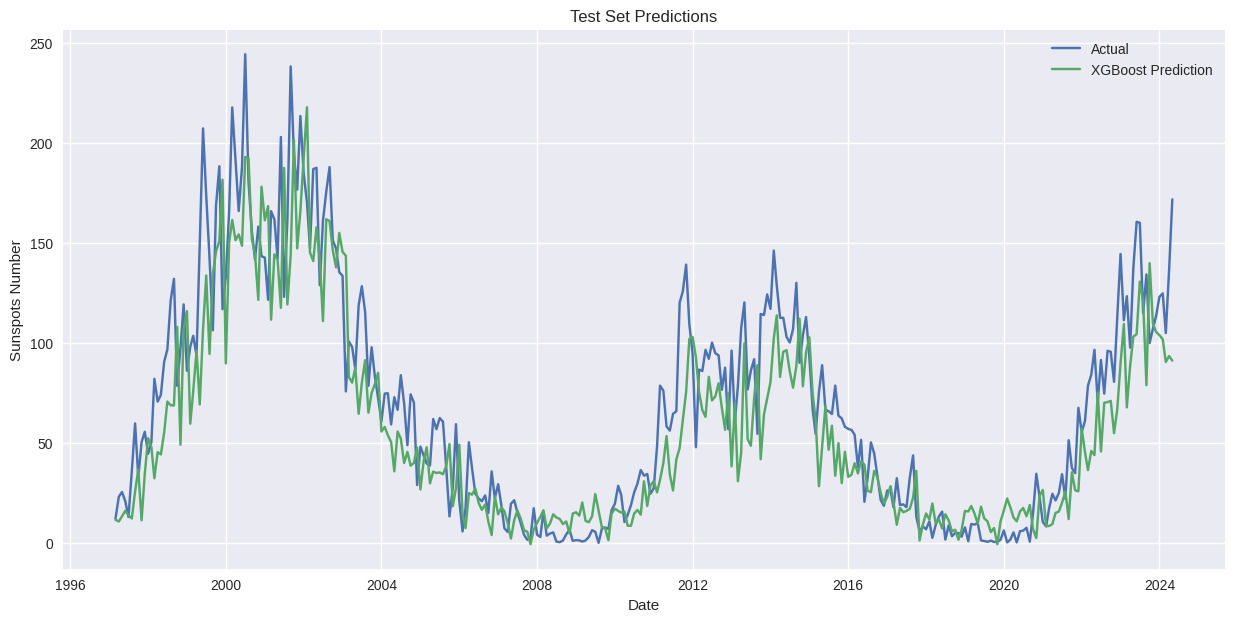

Average Cross-Validation Metrics:
XGBoost: MAE=32.12549605463972, MSE=1659.291672553897, RMSE=40.44831482241372

Test Set Metrics for Best Model (XGBoost):
MAE=20.618267454029223, MSE=782.2261606781975, RMSE=27.968306360561012


In [ ]:
# # Load and prepare the data
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)

# # # Resample data into quarterly intervals
# # df = df.resample('Y').mean()  # Resample into quarterly intervals, you can change 'Q' to 'Q-DEC' or 'Q-JAN' for specific quarterly intervals

# # Split data into train and test sets
# train_size = int(len(df) * 0.9)
# train, test = df.iloc[:train_size], df.iloc[train_size:]

# # # # Feature engineering
# # # train['Quarter'] = train.index.quarter  # Extract quarter from index
# # train['Year'] = train.index.year
# # # test['Quarter'] = test.index.quarter
# # test['Year'] = test.index.year

# # Define lagged features
# lags = [1, 4]  # lagged values for 1 quarter and 1 year (4 quarters)

# for lag in lags:
#     train[f'Sunspots_Number_Lag_{lag}'] = train['Sunspots_Number'].shift(lag)
#     test[f'Sunspots_Number_Lag_{lag}'] = test['Sunspots_Number'].shift(lag)

# train.dropna(inplace=True)
# test.dropna(inplace=True)

# # Define evaluation metrics
# def evaluate_model(model, X_train, y_train, X_test, y_test):
#     model.fit(X_train, y_train)
#     preds = model.predict(X_test)
#     mae = mean_absolute_error(y_test, preds)
#     mse = mean_squared_error(y_test, preds)
#     rmse = np.sqrt(mse)
#     return preds, mae, mse, rmse

# # Define XGBoost and LightGBM models with adjusted parameters
# models = {
#     'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.1, max_depth=5),
# }


# results = {}

# # Perform cross-validation and evaluation on the training data
# tscv = TimeSeriesSplit(n_splits=5)
# for name, model in models.items():
#     maes, mses, rmses = [], [], []
#     for train_index, test_index in tscv.split(train):
#         train_cv, test_cv = train.iloc[train_index], train.iloc[test_index]
#         X_train_cv = train_cv.drop(columns=['Sunspots_Number'])
#         y_train_cv = train_cv['Sunspots_Number']
#         X_test_cv = test_cv.drop(columns=['Sunspots_Number'])
#         y_test_cv = test_cv['Sunspots_Number']
#         preds, mae, mse, rmse = evaluate_model(model, X_train_cv, y_train_cv, X_test_cv, y_test_cv)
#         maes.append(mae)
#         mses.append(mse)
#         rmses.append(rmse)

#     results[name] = {'MAE': np.mean(maes), 'MSE': np.mean(mses), 'RMSE': np.mean(rmses)}

# # Determine the best model based on MAE
# best_model_name = min(results, key=lambda name: results[name]['MAE'])
# best_model = models[best_model_name]

# # Fit the best model on the entire training data
# X_train = train.drop(columns=['Sunspots_Number'])
# y_train = train['Sunspots_Number']
# X_test = test.drop(columns=['Sunspots_Number'])
# best_model.fit(X_train, y_train)
# test_preds = best_model.predict(X_test)

# # Compute test set metrics
# test_mae = mean_absolute_error(test['Sunspots_Number'], test_preds)
# test_mse = mean_squared_error(test['Sunspots_Number'], test_preds)
# test_rmse = np.sqrt(test_mse)

# # Plotting the predictions
# plt.figure(figsize=(15, 7))
# plt.plot(test.index, test['Sunspots_Number'], label='Actual')
# plt.plot(test.index, test_preds, label=f'{best_model_name} Prediction')
# plt.legend()
# plt.title('Test Set Predictions')
# plt.xlabel('Date')
# plt.ylabel('Sunspots Number')
# plt.show()

# # Print results
# print("Average Cross-Validation Metrics:")
# for model_name, metrics in results.items():
#     print(f"{model_name}: MAE={metrics['MAE']}, MSE={metrics['MSE']}, RMSE={metrics['RMSE']}")

# print(f"\nTest Set Metrics for Best Model ({best_model_name}):")
# print(f"MAE={test_mae}, MSE={test_mse}, RMSE={test_rmse}")


In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import pandas as pd
# import numpy as np
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# from sklearn.model_selection import TimeSeriesSplit
# import xgboost as xgb
# import lightgbm as lgb

# # Split data into train and test sets
# train_size = int(len(df) * 0.9)
# train, test = df.iloc[:train_size], df.iloc[train_size:]

# # Fit the best model on the entire training data
# X_train = train.drop(columns=['Sunspots_Number'])
# y_train = train['Sunspots_Number']
# X_test = test.drop(columns=['Sunspots_Number'])
# best_model.fit(X_train, y_train)
# test_preds = best_model.predict(X_test)

# # Compute test set metrics
# test_mae = mean_absolute_error(test['Sunspots_Number'], test_preds)
# test_mse = mean_squared_error(test['Sunspots_Number'], test_preds)
# test_rmse = np.sqrt(test_mse)

NameError: name 'best_model' is not defined

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 2970, number of used features: 5
[LightGBM] [Info] Start training from score 83.423333


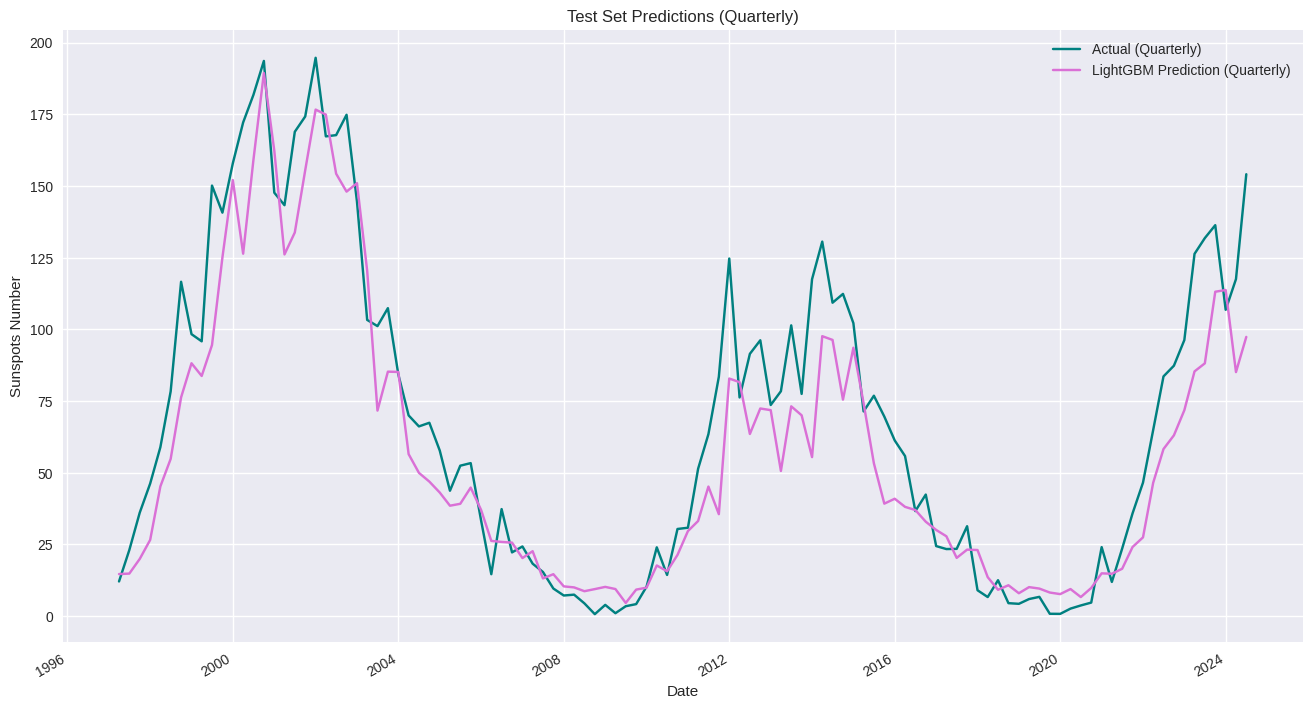

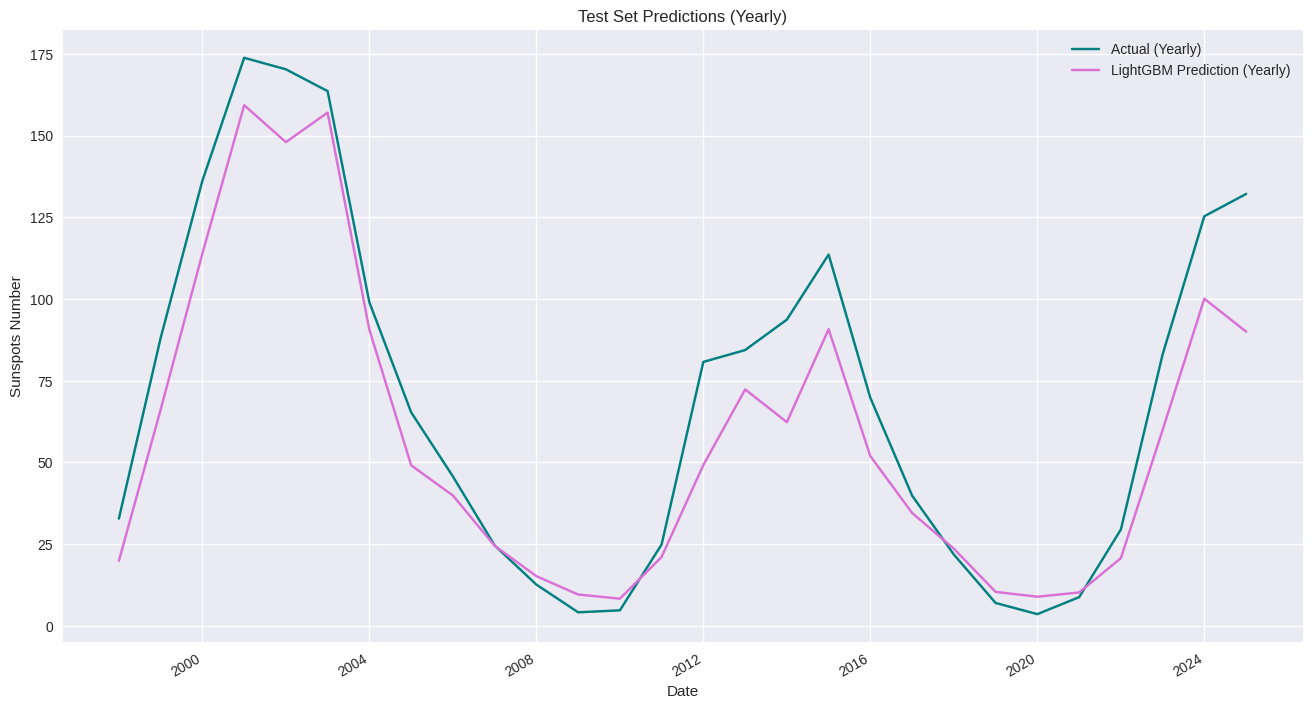


Test Set Metrics for Best Model (LightGBM):
MAE=19.36830460179878, MSE=713.3840676830455, RMSE=26.70925060130002


In [ ]:
# # Prepare the data for plotting
# test_results = pd.DataFrame({
#     'Actual': test['Sunspots_Number'],
#     'Predicted': test_preds
# }, index=test.index)

# # Resample data for quarterly and yearly plotting
# test_results_quarterly = test_results.resample('Q').mean()
# test_results_yearly = test_results.resample('Y').mean()

# # Plotting quarterly data
# plt.plot(test_results_quarterly.index, test_results_quarterly['Actual'], label='Actual (Quarterly)', color='teal')
# plt.plot(test_results_quarterly.index, test_results_quarterly['Predicted'], label=f'{best_model_name} Prediction (Quarterly)', color='orchid')
# plt.gca().xaxis.set_major_locator(mdates.YearLocator(4))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.gcf().autofmt_xdate()
# plt.legend()
# plt.title('Test Set Predictions (Quarterly)')
# plt.xlabel('Date')
# plt.ylabel('Sunspots Number')
# plt.grid(True)
# plt.show()

# # Plotting yearly data
# plt.plot(test_results_yearly.index, test_results_yearly['Actual'], label='Actual (Yearly)', color='teal')
# plt.plot(test_results_yearly.index, test_results_yearly['Predicted'], label=f'{best_model_name} Prediction (Yearly)', color='orchid')
# plt.gca().xaxis.set_major_locator(mdates.YearLocator(4))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.gcf().autofmt_xdate()
# plt.legend()
# plt.title('Test Set Predictions (Yearly)')
# plt.xlabel('Date')
# plt.ylabel('Sunspots Number')
# plt.grid(True)
# plt.show()


# print(f"\nTest Set Metrics for Best Model ({best_model_name}):")
# print(f"MAE={test_mae}, MSE={test_mse}, RMSE={test_rmse}")


##Grid Search and Predictions

I have already done the grid search and kept the best values

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
import lightgbm as lgb
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


# Resample data into quarterly intervals
df = df.resample('Q').mean()  # Resample into quarterly intervals, you can change 'Q' to 'Q-DEC' or 'Q-JAN' for specific quarterly intervals

# Load and prepare the data

# # # Feature engineering
# train['Quarter'] = train.index.quarter  # Extract quarter from index
# train['Year'] = train.index.year
# test['Quarter'] = test.index.quarter
# test['Year'] = test.index.year


# Split data into train and test sets
train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Define lagged features
lags = [1,2,3,4,5,6,7,8,9]  # lagged values for 1 quarter and 1 year (4 quarters)

for lag in lags:
    train[f'Sunspots_Number_Lag_{lag}'] = train['Sunspots_Number'].shift(lag)
    # test[f'Sunspots_Number_Lag_{lag}'] = test['Sunspots_Number'].shift(lag)

train.dropna(inplace=True)
test.dropna(inplace=True)

# Prepare the training data for grid search
X_train = train.drop(columns=['Sunspots_Number'])
y_train = train['Sunspots_Number']

# Define the parameter grid for XGBoost and LightGBM
param_grid_xgb = {
    'n_estimators': [500],
    'learning_rate': [0.01],
    'max_depth': [3],
    'subsample': [0.6],
    'min_child_weight': [5],
    'gamma': [0],
}

param_grid_lgb = {
    'n_estimators': [500],
    'learning_rate': [0.01],
    'max_depth': [3],
    'subsample': [0.6],
    'num_leaves': [31],
    'min_child_samples': [30],
    'boosting_type': ['gbdt'],
}

# Initialize models
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
lgb_model = lgb.LGBMRegressor(objective='regression')

# Perform grid search with cross-validation for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_absolute_error')
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_

# Perform grid search with cross-validation for LightGBM
grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=param_grid_lgb, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_absolute_error')
grid_search_lgb.fit(X_train, y_train)
best_lgb = grid_search_lgb.best_estimator_

# Evaluate both models on the test set
X_test = test.drop(columns=['Sunspots_Number'])
y_test = test['Sunspots_Number']

best_xgb.fit(X_train, y_train)
xgb_preds = best_xgb.predict(X_test)

best_lgb.fit(X_train, y_train)
lgb_preds = best_lgb.predict(X_test)

# Compute test set metrics for both models
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_mse = mean_squared_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(xgb_mse)

lgb_mae = mean_absolute_error(y_test, lgb_preds)
lgb_mse = mean_squared_error(y_test, lgb_preds)
lgb_rmse = np.sqrt(lgb_mse)

# Determine the best model based on MAE
best_model_name = 'XGBoost' if xgb_mae < lgb_mae else 'LightGBM'
best_model_preds = xgb_preds if best_model_name == 'XGBoost' else lgb_preds

# Prepare the data for plotting
test_results = pd.DataFrame({
    'Actual': y_test,
    'XGBoost_Predicted': xgb_preds,
    'LightGBM_Predicted': lgb_preds
}, index=test.index)

# # Resample data for quarterly and yearly plotting
# test_results = test_results.resample('Q').mean()
# test_results_yearly = test_results.resample('Y').mean()

# Plotting quarterly data
plt.figure(figsize=(15, 7))
plt.plot(test_results.index, test_results['Actual'], label='Actual (Quarterly)', color='teal')
plt.plot(test_results.index, test_results['XGBoost_Predicted'], label='XGBoost Prediction (Quarterly)', color='orchid')
plt.plot(test_results.index, test_results['LightGBM_Predicted'], label='LightGBM Prediction (Quarterly)', color='coral')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.title('Test Set Predictions (Quarterly)')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.grid(True)
plt.show()

# # Plotting yearly data
# plt.figure(figsize=(15, 7))
# plt.plot(test_results_yearly.index, test_results_yearly['Actual'], label='Actual (Yearly)', color='teal')
# plt.plot(test_results_yearly.index, test_results_yearly['XGBoost_Predicted'], label='XGBoost Prediction (Yearly)', color='orchid')
# plt.plot(test_results_yearly.index, test_results_yearly['LightGBM_Predicted'], label='LightGBM Prediction (Yearly)', color='coral')
# plt.gca().xaxis.set_major_locator(mdates.YearLocator(4))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.gcf().autofmt_xdate()
# plt.legend()
# plt.title('Test Set Predictions (Yearly)')
# plt.xlabel('Date')
# plt.ylabel('Sunspots Number')
# plt.grid(True)
# plt.show()

# Print results
print(f"Best Parameters from Grid Search for XGBoost: {grid_search_xgb.best_params_}")
print(f"Best Parameters from Grid Search for LightGBM: {grid_search_lgb.best_params_}")

print(f"\nTest Set Metrics for XGBoost:")
print(f"MAE={xgb_mae}, MSE={xgb_mse}, RMSE={xgb_rmse}")

print(f"\nTest Set Metrics for LightGBM:")
print(f"MAE={lgb_mae}, MSE={lgb_mse}, RMSE={lgb_rmse}")

print(f"\nBest Model: {best_model_name}")
print(f"MAE={min(xgb_mae, lgb_mae)}, MSE={min(xgb_mse, lgb_mse)}, RMSE={min(xgb_rmse, lgb_rmse)}")


<ipython-input-5-09146d6bcd46>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'Sunspots_Number_Lag_{lag}'] = train['Sunspots_Number'].shift(lag)
<ipython-input-5-09146d6bcd46>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'Sunspots_Number_Lag_{lag}'] = train['Sunspots_Number'].shift(lag)
<ipython-input-5-09146d6bcd46>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 618
[LightGBM] [Info] Number of data points in the train set: 167, number of used features: 12
[LightGBM] [Info] Start training from score 98.163473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

ValueError: feature_names mismatch: ['Year', 'Month', 'Date_Fraction', 'Sunspots_Number_Lag_1', 'Sunspots_Number_Lag_2', 'Sunspots_Number_Lag_3', 'Sunspots_Number_Lag_4', 'Sunspots_Number_Lag_5', 'Sunspots_Number_Lag_6', 'Sunspots_Number_Lag_7', 'Sunspots_Number_Lag_8', 'Sunspots_Number_Lag_9'] ['Year', 'Month', 'Date_Fraction']
expected Sunspots_Number_Lag_1, Sunspots_Number_Lag_3, Sunspots_Number_Lag_4, Sunspots_Number_Lag_5, Sunspots_Number_Lag_7, Sunspots_Number_Lag_9, Sunspots_Number_Lag_2, Sunspots_Number_Lag_6, Sunspots_Number_Lag_8 in input data

lagged

In [ ]:
# Define the lag values to evaluate
lags = range(6)  # Example: 1 quarter, 2 quarters, etc.

# Initialize lists to store results
results = []

for lag in lags:
    # Create lag features for the train and test datasets
    train_lag = train.copy()
    test_lag = test.copy()
    train_lag[f'Sunspots_Number_Lag_{lag}'] = train['Sunspots_Number'].shift(lag)
    test_lag[f'Sunspots_Number_Lag_{lag}'] = test['Sunspots_Number'].shift(lag)

    # Drop rows with missing values due to lagging
    train_lag.dropna(inplace=True)
    test_lag.dropna(inplace=True)

    # Prepare the data for the current lag value
    X_train_lag = train_lag.drop(columns=['Sunspots_Number'])
    y_train_lag = train_lag['Sunspots_Number']
    X_test_lag = test_lag.drop(columns=['Sunspots_Number'])
    y_test_lag = test_lag['Sunspots_Number']

    # Fit XGBoost model
    best_xgb.fit(X_train_lag, y_train_lag)
    xgb_preds_lag = best_xgb.predict(X_test_lag)

    # Fit LightGBM model
    best_lgb.fit(X_train_lag, y_train_lag)
    lgb_preds_lag = best_lgb.predict(X_test_lag)

    # Compute metrics
    xgb_mae_lag = mean_absolute_error(y_test_lag, xgb_preds_lag)
    xgb_mse_lag = mean_squared_error(y_test_lag, xgb_preds_lag)
    xgb_rmse_lag = np.sqrt(xgb_mse_lag)

    lgb_mae_lag = mean_absolute_error(y_test_lag, lgb_preds_lag)
    lgb_mse_lag = mean_squared_error(y_test_lag, lgb_preds_lag)
    lgb_rmse_lag = np.sqrt(lgb_mse_lag)

    # Store results
    results.append({
        'Lag': lag,
        'XGBoost_MAE': xgb_mae_lag,
        'XGBoost_MSE': xgb_mse_lag,
        'XGBoost_RMSE': xgb_rmse_lag,
        'LightGBM_MAE': lgb_mae_lag,
        'LightGBM_MSE': lgb_mse_lag,
        'LightGBM_RMSE': lgb_rmse_lag
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)


ValueError: feature_names mismatch: ['Year', 'Month', 'Date_Fraction', 'Sunspots_Number_Lag_1', 'Sunspots_Number_Lag_2', 'Sunspots_Number_Lag_3', 'Sunspots_Number_Lag_4', 'Sunspots_Number_Lag_5', 'Sunspots_Number_Lag_6', 'Sunspots_Number_Lag_7', 'Sunspots_Number_Lag_8', 'Sunspots_Number_Lag_9', 'Sunspots_Number_Lag_0'] ['Year', 'Month', 'Date_Fraction', 'Sunspots_Number_Lag_0']
expected Sunspots_Number_Lag_1, Sunspots_Number_Lag_3, Sunspots_Number_Lag_4, Sunspots_Number_Lag_5, Sunspots_Number_Lag_7, Sunspots_Number_Lag_9, Sunspots_Number_Lag_2, Sunspots_Number_Lag_6, Sunspots_Number_Lag_8 in input data

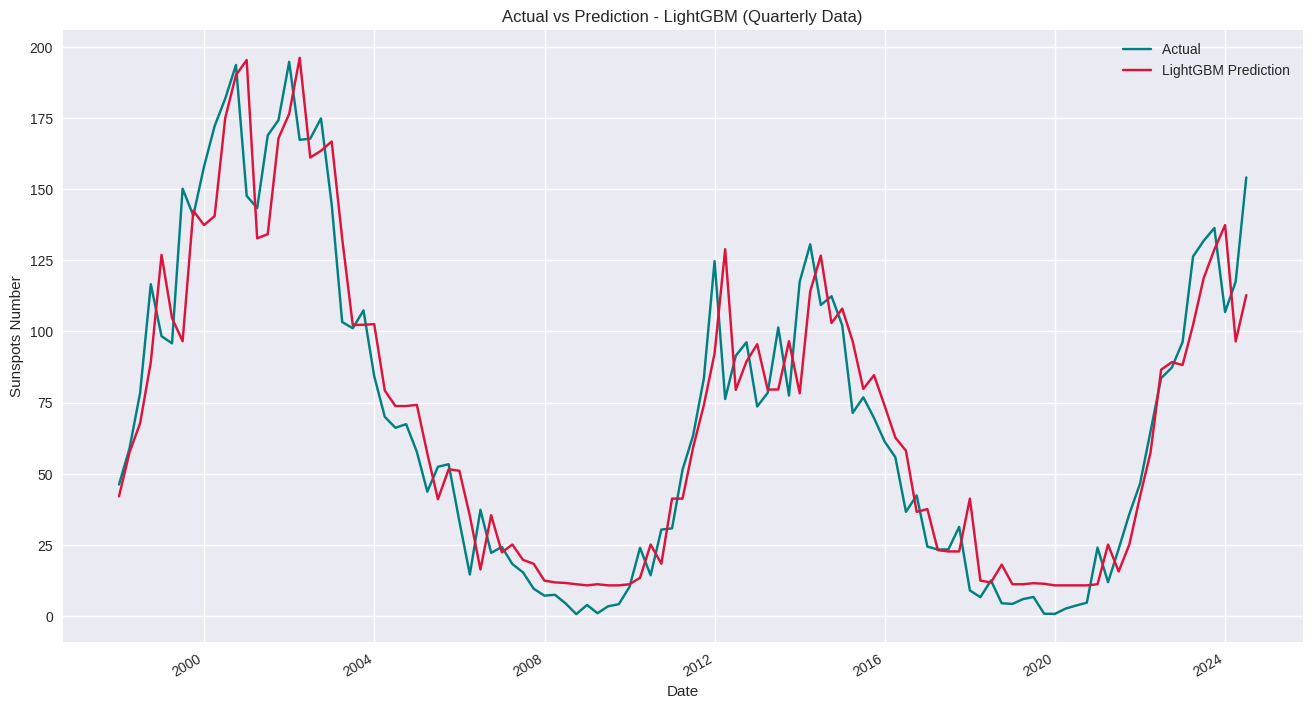

Best Parameters from Grid Search for XGBoost: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.6}
Best Parameters from Grid Search for LightGBM: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'min_child_samples': 30, 'n_estimators': 500, 'num_leaves': 31, 'subsample': 0.6}

Test Set Metrics for XGBoost:
MAE=13.394393454459598, MSE=302.1928765397048, RMSE=17.383695710052706

Test Set Metrics for LightGBM:
MAE=13.208274020390622, MSE=297.95746241369295, RMSE=17.261444389554804

Best Model: LightGBM
MAE=13.208274020390622, MSE=297.95746241369295, RMSE=17.261444389554804


In [ ]:
# Plotting quarterly data
# plt.figure(figsize=(16, 9))
plt.plot(test_results.index, test_results['Actual'], label='Actual ', color='teal')
# plt.plot(test_results.index, test_results['XGBoost_Predicted'], label='XGBoost Prediction', color='orchid')
plt.plot(test_results.index, test_results['LightGBM_Predicted'], label='LightGBM Prediction', color='crimson')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.title('Actual vs Prediction - LightGBM (Quarterly Data)')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.grid(True)
plt.show()

# # Plotting yearly data
# plt.figure(figsize=(15, 7))
# plt.plot(test_results_yearly.index, test_results_yearly['Actual'], label='Actual (Yearly)', color='teal')
# plt.plot(test_results_yearly.index, test_results_yearly['XGBoost_Predicted'], label='XGBoost Prediction (Yearly)', color='orchid')
# plt.plot(test_results_yearly.index, test_results_yearly['LightGBM_Predicted'], label='LightGBM Prediction (Yearly)', color='coral')
# plt.gca().xaxis.set_major_locator(mdates.YearLocator(4))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.gcf().autofmt_xdate()
# plt.legend()
# plt.title('Test Set Predictions (Yearly)')
# plt.xlabel('Date')
# plt.ylabel('Sunspots Number')
# plt.grid(True)
# plt.show()

# Print results
print(f"Best Parameters from Grid Search for XGBoost: {grid_search_xgb.best_params_}")
print(f"Best Parameters from Grid Search for LightGBM: {grid_search_lgb.best_params_}")

print(f"\nTest Set Metrics for XGBoost:")
print(f"MAE={xgb_mae}, MSE={xgb_mse}, RMSE={xgb_rmse}")

print(f"\nTest Set Metrics for LightGBM:")
print(f"MAE={lgb_mae}, MSE={lgb_mse}, RMSE={lgb_rmse}")

print(f"\nBest Model: {best_model_name}")
print(f"MAE={min(xgb_mae, lgb_mae)}, MSE={min(xgb_mse, lgb_mse)}, RMSE={min(xgb_rmse, lgb_rmse)}")


In [ ]:
# Check if indices are aligned
print(f"Test set indices:\n{test_results.index}")
print(f"Test set actual values:\n{test_results['Actual'].head()}")
print(f"Test set predictions:\n{test_results[['LightGBM_Predicted', 'XGBoost_Predicted']].head()}")

# Print metrics for debugging
print(f"LightGBM MAE: {lgb_mae}")
print(f"XGBoost MAE: {xgb_mae}")


Test set indices:
DatetimeIndex(['2022-03-31', '2022-06-30', '2022-09-30', '2022-12-31',
               '2023-03-31', '2023-06-30', '2023-09-30', '2023-12-31',
               '2024-03-31', '2024-06-30'],
              dtype='datetime64[ns]', name='Date', freq='Q-DEC')
Test set actual values:
Date
2022-03-31     64.933333
2022-06-30     83.600000
2022-09-30     87.333333
2022-12-31     96.266667
2023-03-31    126.333333
Freq: Q-DEC, Name: Actual, dtype: float64
Test set predictions:
            LightGBM_Predicted  XGBoost_Predicted
Date                                             
2022-03-31           62.521182          62.492649
2022-06-30           82.659716          82.587074
2022-09-30           92.626947          91.772964
2022-12-31           96.086453          96.012405
2023-03-31          100.443941         104.534370
LightGBM MAE: 16.239875260680034
XGBoost MAE: 16.61230764461286


25/7

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR

# Assuming 'filtered_data' is your DataFrame
# Add more lagged features
def add_lagged_features(df, lags):
    for lag in lags:
        df[f'Sunspots_Number_Lag_{lag}'] = df['Sunspots_Number'].shift(lag)
    return df

# Add lagged features
lagged_values = [1, 2,3,4,5,6]  # Add more lags here if needed
filtered_data = add_lagged_features(filtered_data, lagged_values)

# Set the target variable for one-step-ahead prediction
filtered_data['Sunspots_Number_Target'] = filtered_data['Sunspots_Number'].shift(-1)

# Drop rows with NaN values due to lagging and shifting
filtered_data = filtered_data.dropna()

# Define feature sets
lagged_features = [f'Sunspots_Number_Lag_{lag}' for lag in lagged_values]
full_features = lagged_features + ['Ap', 'F10.7obs']

# Split Data into Train and Test
train_size = int(len(filtered_data) * 0.9)  # 90% train, 10% test
train_data = filtered_data.iloc[:train_size]
test_data = filtered_data.iloc[train_size:]

# Initialize lists to store validation metrics across folds
metrics = {
    'RandomForest_Lagged': {'mae': [], 'rmse': [], 'r2': []},
    'RandomForest_Full': {'mae': [], 'rmse': [], 'r2': []},
    'XGBoost_Lagged': {'mae': [], 'rmse': [], 'r2': []},
    'XGBoost_Full': {'mae': [], 'rmse': [], 'r2': []},
    'LightGBM_Lagged': {'mae': [], 'rmse': [], 'r2': []},
    'LightGBM_Full': {'mae': [], 'rmse': [], 'r2': []},
    'SVR_Lagged': {'mae': [], 'rmse': [], 'r2': []},
    'SVR_Full': {'mae': [], 'rmse': [], 'r2': []}
}

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    model.fit(X_train, y_train)
    preds_val = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds_val))
    r2 = r2_score(y_val, preds_val)
    return mae, rmse, r2

# Train and Evaluate Models for Lagged Features
for train_index, val_index in tscv.split(train_data):
    train_fold = train_data.iloc[train_index]
    val_fold = train_data.iloc[val_index]

    X_train_lagged = train_fold[lagged_features]
    y_train_lagged = train_fold['Sunspots_Number_Target']
    X_val_lagged = val_fold[lagged_features]
    y_val_lagged = val_fold['Sunspots_Number_Target']

    # RandomForest with Lagged Features
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    mae, rmse, r2 = evaluate_model(rf_model, X_train_lagged, y_train_lagged, X_val_lagged, y_val_lagged, 'RandomForest_Lagged')
    metrics['RandomForest_Lagged']['mae'].append(mae)
    metrics['RandomForest_Lagged']['rmse'].append(rmse)
    metrics['RandomForest_Lagged']['r2'].append(r2)

    # XGBoost with Lagged Features
    xgb_model = xgb.XGBRegressor(
        gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=5,
        n_estimators=500, subsample=0.6, random_state=42
    )
    mae, rmse, r2 = evaluate_model(xgb_model, X_train_lagged, y_train_lagged, X_val_lagged, y_val_lagged, 'XGBoost_Lagged')
    metrics['XGBoost_Lagged']['mae'].append(mae)
    metrics['XGBoost_Lagged']['rmse'].append(rmse)
    metrics['XGBoost_Lagged']['r2'].append(r2)

    # LightGBM with Lagged Features
    lgb_model = lgb.LGBMRegressor(
        boosting_type='gbdt', learning_rate=0.01, max_depth=3, min_child_samples=30,
        n_estimators=500, num_leaves=31, subsample=0.6, random_state=42
    )
    mae, rmse, r2 = evaluate_model(lgb_model, X_train_lagged, y_train_lagged, X_val_lagged, y_val_lagged, 'LightGBM_Lagged')
    metrics['LightGBM_Lagged']['mae'].append(mae)
    metrics['LightGBM_Lagged']['rmse'].append(rmse)
    metrics['LightGBM_Lagged']['r2'].append(r2)

    # SVR with Lagged Features
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    mae, rmse, r2 = evaluate_model(svr_model, X_train_lagged, y_train_lagged, X_val_lagged, y_val_lagged, 'SVR_Lagged')
    metrics['SVR_Lagged']['mae'].append(mae)
    metrics['SVR_Lagged']['rmse'].append(rmse)
    metrics['SVR_Lagged']['r2'].append(r2)

# Compute mean validation metrics for lagged features
mean_metrics_lagged = {model: {metric: np.mean(metrics[model][metric]) for metric in metrics[model]} for model in metrics if 'Lagged' in model}

print("Lagged Features - Mean Validation Metrics:")
for model, metric_values in mean_metrics_lagged.items():
    print(f"{model} - Mean Validation MAE: {metric_values['mae']:.2f}, Mean Validation RMSE: {metric_values['rmse']:.2f}, Mean Validation R^2: {metric_values['r2']:.4f}")

# Train final models on entire training set with lagged features
X_train_lagged = train_data[lagged_features]
y_train_lagged = train_data['Sunspots_Number_Target']
X_test_lagged = test_data[lagged_features]
y_test_lagged = test_data['Sunspots_Number_Target']

# Evaluate models with lagged features on the test set
results_lagged = {}
for model_name in metrics:
    if 'Lagged' in model_name:
        model_class = {
            'RandomForest_Lagged': RandomForestRegressor(n_estimators=100, random_state=42),
            'XGBoost_Lagged': xgb.XGBRegressor(
                gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=5,
                n_estimators=500, subsample=0.6, random_state=42
            ),
            'LightGBM_Lagged': lgb.LGBMRegressor(
                boosting_type='gbdt', learning_rate=0.01, max_depth=3, min_child_samples=30,
                n_estimators=500, num_leaves=31, subsample=0.6, random_state=42
            ),
            'SVR_Lagged': SVR(kernel='rbf', C=1.0, epsilon=0.1)
        }[model_name]
        mae, rmse, r2 = final_evaluation(model_class, X_train_lagged, y_train_lagged, X_test_lagged, y_test_lagged, model_name)
        results_lagged[model_name] = {'MAE': mae, 'RMSE': rmse, 'R^2': r2}

print("\nLagged Features - Test Metrics:")
for model, metric_values in results_lagged.items():
    print(f"{model} - Test MAE: {metric_values['MAE']:.2f}, Test RMSE: {metric_values['RMSE']:.4f}, Test R^2: {metric_values['R^2']:.4f}")

# Train and Evaluate Models for Full Features
for train_index, val_index in tscv.split(train_data):
    train_fold = train_data.iloc[train_index]
    val_fold = train_data.iloc[val_index]

    X_train_full = train_fold[full_features]
    y_train_full = train_fold['Sunspots_Number_Target']
    X_val_full = val_fold[full_features]
    y_val_full = val_fold['Sunspots_Number_Target']

    # RandomForest with Full Features
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    mae, rmse, r2 = evaluate_model(rf_model, X_train_full, y_train_full, X_val_full, y_val_full, 'RandomForest_Full')
    metrics['RandomForest_Full']['mae'].append(mae)
    metrics['RandomForest_Full']['rmse'].append(rmse)
    metrics['RandomForest_Full']['r2'].append(r2)

    # XGBoost with Full Features
    xgb_model = xgb.XGBRegressor(
        gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=5,
        n_estimators=500, subsample=0.6, random_state=42
    )
    mae, rmse, r2 = evaluate_model(xgb_model, X_train_full, y_train_full, X_val_full, y_val_full, 'XGBoost_Full')
    metrics['XGBoost_Full']['mae'].append(mae)
    metrics['XGBoost_Full']['rmse'].append(rmse)
    metrics['XGBoost_Full']['r2'].append(r2)

    # LightGBM with Full Features
    lgb_model = lgb.LGBMRegressor(
        boosting_type='gbdt', learning_rate=0.01, max_depth=3, min_child_samples=30,
        n_estimators=500, num_leaves=31, subsample=0.6, random_state=42
    )
    mae, rmse, r2 = evaluate_model(lgb_model, X_train_full, y_train_full, X_val_full, y_val_full, 'LightGBM_Full')
    metrics['LightGBM_Full']['mae'].append(mae)
    metrics['LightGBM_Full']['rmse'].append(rmse)
    metrics['LightGBM_Full']['r2'].append(r2)

    # SVR with Full Features
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    mae, rmse, r2 = evaluate_model(svr_model, X_train_full, y_train_full, X_val_full, y_val_full, 'SVR_Full')
    metrics['SVR_Full']['mae'].append(mae)
    metrics['SVR_Full']['rmse'].append(rmse)
    metrics['SVR_Full']['r2'].append(r2)

# Compute mean validation metrics for full features
mean_metrics_full = {model: {metric: np.mean(metrics[model][metric]) for metric in metrics[model]} for model in metrics if 'Full' in model}

print("\nFull Features - Mean Validation Metrics:")
for model, metric_values in mean_metrics_full.items():
    print(f"{model} - Mean Validation MAE: {metric_values['mae']:.2f}, Mean Validation RMSE: {metric_values['rmse']:.2f}, Mean Validation R^2: {metric_values['r2']:.4f}")

# Train final models on entire training set with full features
X_train_full = train_data[full_features]
y_train_full = train_data['Sunspots_Number_Target']
X_test_full = test_data[full_features]
y_test_full = test_data['Sunspots_Number_Target']

# Evaluate models with full features on the test set
results_full = {}
for model_name in metrics:
    if 'Full' in model_name:
        model_class = {
            'RandomForest_Full': RandomForestRegressor(n_estimators=100, random_state=42),
            'XGBoost_Full': xgb.XGBRegressor(
                gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=5,
                n_estimators=500, subsample=0.6, random_state=42
            ),
            'LightGBM_Full': lgb.LGBMRegressor(
                boosting_type='gbdt', learning_rate=0.01, max_depth=3, min_child_samples=30,
                n_estimators=500, num_leaves=31, subsample=0.6, random_state=42
            ),
            'SVR_Full': SVR(kernel='rbf', C=1.0, epsilon=0.1)
        }[model_name]
        mae, rmse, r2 = final_evaluation(model_class, X_train_full, y_train_full, X_test_full, y_test_full, model_name)
        results_full[model_name] = {'MAE': mae, 'RMSE': rmse, 'R^2': r2}

print("\nFull Features - Test Metrics:")
for model, metric_values in results_full.items():
    print(f"{model} - Test MAE: {metric_values['MAE']:.2f}, Test RMSE: {metric_values['RMSE']:.4f}, Test R^2: {metric_values['R^2']:.4f}")


NameError: name 'filtered_data' is not defined

<ipython-input-25-d78e4cec851a>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'Sunspots_Number_Lag_{lag}'] = train['Sunspots_Number'].shift(lag)
<ipython-input-25-d78e4cec851a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'Sunspots_Number_Lag_{lag}'] = test['Sunspots_Number'].shift(lag)
<ipython-input-25-d78e4cec851a>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 167, number of used features: 5
[LightGBM] [Info] Start training from score 98.976646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

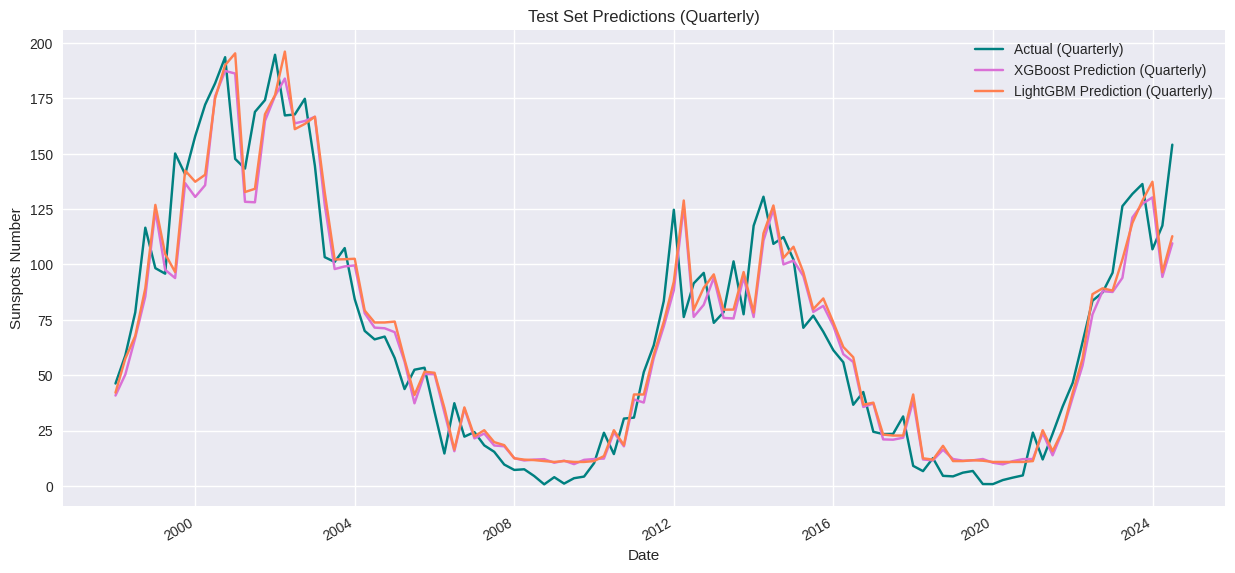

Best Parameters from Grid Search for XGBoost: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.6}
Best Parameters from Grid Search for LightGBM: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'min_child_samples': 30, 'n_estimators': 500, 'num_leaves': 31, 'subsample': 0.6}

Test Set Metrics for XGBoost:
MAE=13.394393454459598, MSE=302.1928765397048, RMSE=17.383695710052706, R^2=0.9006

Test Set Metrics for LightGBM:
MAE=13.208274020390622, MSE=297.95746241369295, RMSE=17.261444389554804, R^2=0.9020

Best Model: LightGBM
MAE=13.208274020390622, MSE=297.95746241369295, RMSE=17.261444389554804, R^2=0.9020


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
import lightgbm as lgb

# Load and prepare the data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample data into quarterly intervals
df = df.resample('Q').mean()  # Resample into quarterly intervals

# Split data into train and test sets
train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Define lagged features
lags = [1, 4]  # lagged values for 1 quarter and 1 year (4 quarters)

for lag in lags:
    train[f'Sunspots_Number_Lag_{lag}'] = train['Sunspots_Number'].shift(lag)
    test[f'Sunspots_Number_Lag_{lag}'] = test['Sunspots_Number'].shift(lag)

train.dropna(inplace=True)
test.dropna(inplace=True)

# Prepare the training data for grid search
X_train = train.drop(columns=['Sunspots_Number'])
y_train = train['Sunspots_Number']

# Define the parameter grid for XGBoost and LightGBM
param_grid_xgb = {
    'n_estimators': [500],
    'learning_rate': [0.01],
    'max_depth': [3],
    'subsample': [0.6],
    'min_child_weight': [5],
    'gamma': [0],
}

param_grid_lgb = {
    'n_estimators': [500],
    'learning_rate': [0.01],
    'max_depth': [3],
    'subsample': [0.6],
    'num_leaves': [31],
    'min_child_samples': [30],
    'boosting_type': ['gbdt'],
}

# Initialize models
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
lgb_model = lgb.LGBMRegressor(objective='regression')

# Perform grid search with cross-validation for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_absolute_error')
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_

# Perform grid search with cross-validation for LightGBM
grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=param_grid_lgb, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_absolute_error')
grid_search_lgb.fit(X_train, y_train)
best_lgb = grid_search_lgb.best_estimator_

# Evaluate both models on the test set
X_test = test.drop(columns=['Sunspots_Number'])
y_test = test['Sunspots_Number']

best_xgb.fit(X_train, y_train)
xgb_preds = best_xgb.predict(X_test)

best_lgb.fit(X_train, y_train)
lgb_preds = best_lgb.predict(X_test)

# Compute test set metrics for both models
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_mse = mean_squared_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_preds)

lgb_mae = mean_absolute_error(y_test, lgb_preds)
lgb_mse = mean_squared_error(y_test, lgb_preds)
lgb_rmse = np.sqrt(lgb_mse)
lgb_r2 = r2_score(y_test, lgb_preds)

# Determine the best model based on MAE
best_model_name = 'XGBoost' if xgb_mae < lgb_mae else 'LightGBM'
best_model_preds = xgb_preds if best_model_name == 'XGBoost' else lgb_preds

# Prepare the data for plotting
test_results = pd.DataFrame({
    'Actual': y_test,
    'XGBoost_Predicted': xgb_preds,
    'LightGBM_Predicted': lgb_preds
}, index=test.index)

# Plotting quarterly data
plt.figure(figsize=(15, 7))
plt.plot(test_results.index, test_results['Actual'], label='Actual (Quarterly)', color='teal')
plt.plot(test_results.index, test_results['XGBoost_Predicted'], label='XGBoost Prediction (Quarterly)', color='orchid')
plt.plot(test_results.index, test_results['LightGBM_Predicted'], label='LightGBM Prediction (Quarterly)', color='coral')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.title('Test Set Predictions (Quarterly)')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.grid(True)
plt.show()

# Print results
print(f"Best Parameters from Grid Search for XGBoost: {grid_search_xgb.best_params_}")
print(f"Best Parameters from Grid Search for LightGBM: {grid_search_lgb.best_params_}")

print(f"\nTest Set Metrics for XGBoost:")
print(f"MAE={xgb_mae}, MSE={xgb_mse}, RMSE={xgb_rmse}, R^2={xgb_r2:.4f}")

print(f"\nTest Set Metrics for LightGBM:")
print(f"MAE={lgb_mae}, MSE={lgb_mse}, RMSE={lgb_rmse}, R^2={lgb_r2:.4f}")

print(f"\nBest Model: {best_model_name}")
print(f"MAE={min(xgb_mae, lgb_mae)}, MSE={min(xgb_mse, lgb_mse)}, RMSE={min(xgb_rmse, lgb_rmse)}, R^2={max(xgb_r2, lgb_r2):.4f}")


In [ ]:
# Load and prepare the data
# df = pd.read_csv('your_data.csv')  # Load your dataset
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample data into quarterly intervals
df = df.resample('Q').mean()  # Resample into quarterly intervals


##with cross

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load and prepare the data
# Assuming df is your dataframe with 'Date' and 'Sunspots_Number' columns

# Convert 'Date' to datetime and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample data to quarterly frequency
df = df.resample('Q').mean()  # Adjust as needed, e.g., 'Q' for quarterly

# Perform seasonal decomposition
result = seasonal_decompose(df['Sunspots_Number'], model='additive', period=4)  # Assuming quarterly periodicity
df['Seasonal'] = result.seasonal

# Split data into train and test sets (considering last 20% as test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Feature engineering
train['Quarter'] = train.index.quarter
train['Year'] = train.index.year
test['Quarter'] = test.index.quarter
test['Year'] = test.index.year

# Define lagged features
lags = [1, 4]  # lagged values for 1 quarter and 1 year (adjust as needed for quarterly data)

for lag in lags:
    train[f'Sunspots_Number_Lag_{lag}'] = train['Sunspots_Number'].shift(lag)
    test[f'Sunspots_Number_Lag_{lag}'] = test['Sunspots_Number'].shift(lag)

train.dropna(inplace=True)
test.dropna(inplace=True)

# Define evaluation metrics
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    return preds, mae, mse, rmse

# Define LightGBM model with adjusted parameters
lgb_params = {
    'num_leaves': 50,
    'max_depth': 10,
    'learning_rate': 0.05,
    'n_estimators': 500,
    'min_child_samples': 20
}

# Perform cross-validation and evaluation on the training data
results = {}
tscv = TimeSeriesSplit(n_splits=5)
maes, mses, rmses = [], [], []

for train_index, test_index in tscv.split(train):
    train_cv, test_cv = train.iloc[train_index], train.iloc[test_index]
    X_train_cv = train_cv.drop(columns=['Sunspots_Number'])
    y_train_cv = train_cv['Sunspots_Number']
    X_test_cv = test_cv.drop(columns=['Sunspots_Number'])
    y_test_cv = test_cv['Sunspots_Number']

    lgb_model = lgb.LGBMRegressor(**lgb_params)
    preds, mae, mse, rmse = evaluate_model(lgb_model, X_train_cv, y_train_cv, X_test_cv, y_test_cv)
    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)

results['LightGBM'] = {
    'MAE': np.mean(maes),
    'MSE': np.mean(mses),
    'RMSE': np.mean(rmses)
}

# Fit the LightGBM model on the entire training data
X_train = train.drop(columns=['Sunspots_Number'])
y_train = train['Sunspots_Number']
X_test = test.drop(columns=['Sunspots_Number'])

final_lgb_model = lgb.LGBMRegressor(**lgb_params)
final_lgb_model.fit(X_train, y_train)
test_preds = final_lgb_model.predict(X_test)

# Compute test set metrics
test_mae = mean_absolute_error(test['Sunspots_Number'], test_preds)
test_mse = mean_squared_error(test['Sunspots_Number'], test_preds)
test_rmse = np.sqrt(test_mse)

# Plotting the predictions
plt.figure(figsize=(15, 7))
plt.plot(test.index, test['Sunspots_Number'], label='Actual')
plt.plot(test.index, test_preds, label='LightGBM Prediction')
plt.legend()
plt.title('Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.show()

# Print results
print("Average Cross-Validation Metrics:")
for model_name, metrics in results.items():
    print(f"{model_name}: MAE={metrics['MAE']}, MSE={metrics['MSE']}, RMSE={metrics['RMSE']}")

print(f"\nTest Set Metrics for LightGBM:")
print(f"MAE={test_mae}, MSE={test_mse}, RMSE={test_rmse}")


##RD and SVR

In the provided implementation, the TimeSeriesSplit object tscv is used to perform cross-validation on the training data (train). This means that during each fold of cross-validation, the model trains on a subset of the training data (train_cv) and evaluates on another subset (test_cv). After cross-validation, the model is trained on the entire training data (train) and evaluated on the completely unseen test data (test).

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)


<ipython-input-60-2bae5c7a9ea6>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Quarter'] = train.index.quarter
<ipython-input-60-2bae5c7a9ea6>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Year'] = train.index.year
<ipython-input-60-2bae5c7a9ea6>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

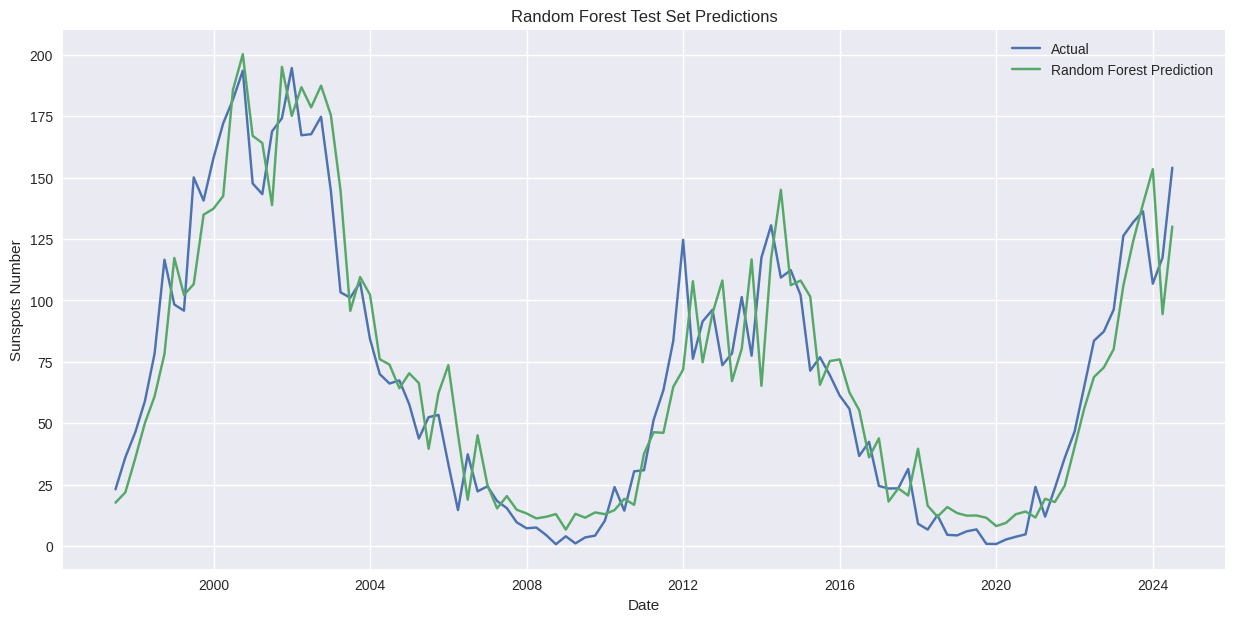

Random Forest Cross-Validation Metrics:
RandomForest: MAE=19.97632536057713, MSE=754.9299204652723, RMSE=27.032662232125

Random Forest Test Set Metrics:
MAE=14.792837665669623, MSE=355.5000381394614, RMSE=18.854708646368987


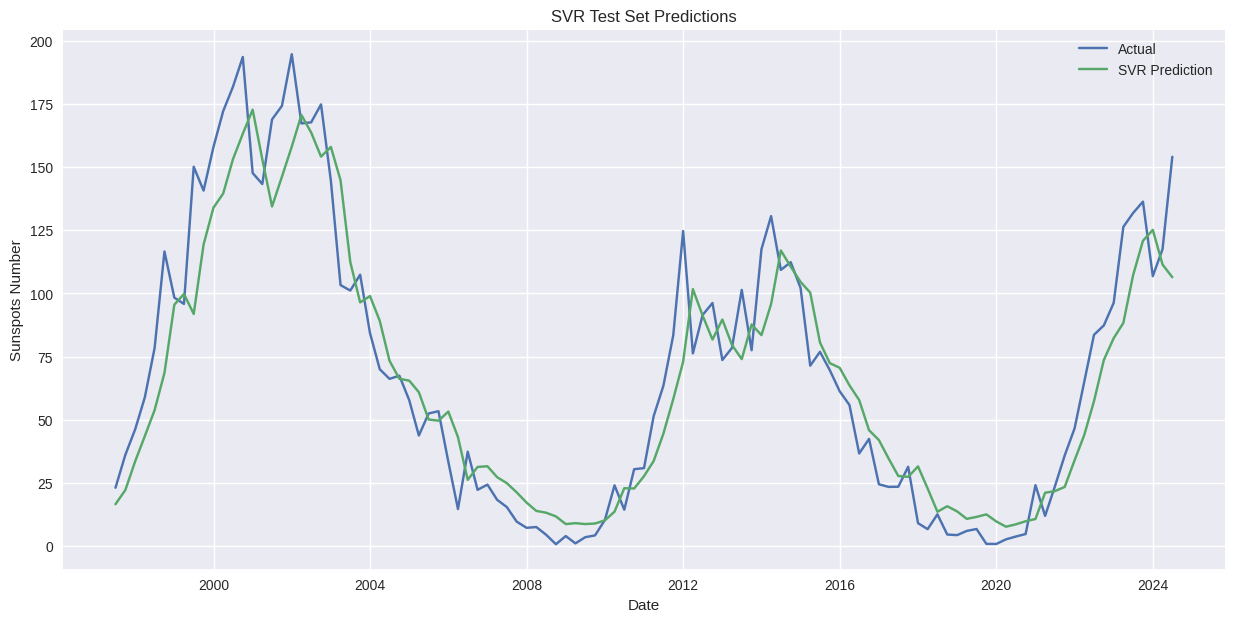

SVR Cross-Validation Metrics:
SVR: MAE=22.22408592898944, MSE=866.8813486529358, RMSE=28.96215394109809

SVR Test Set Metrics:
MAE=14.804378124592699, MSE=363.64859239373055, RMSE=19.06957242293939


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Assuming df is your dataframe with 'Date' and 'Sunspots_Number' columns

# Convert 'Date' to datetime and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample data to quarterly frequency
df = df.resample('Q').mean()  # Adjust as needed, e.g., 'Q' for quarterly

# Perform seasonal decomposition
result = seasonal_decompose(df['Sunspots_Number'], model='additive', period=4)  # Assuming quarterly periodicity
df['Seasonal'] = result.seasonal

# Split data into train and test sets (considering last 20% as test)
train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Feature engineering
train['Quarter'] = train.index.quarter
train['Year'] = train.index.year
test['Quarter'] = test.index.quarter
test['Year'] = test.index.year

# Define lagged features
lags = [1, 2, 3 ,4 ,5 ,6]  # lagged values for 1 quarter and 1 year (adjust as needed for quarterly data)

for lag in lags:
    train[f'Sunspots_Number_Lag_{lag}'] = train['Sunspots_Number'].shift(lag)
    test[f'Sunspots_Number_Lag_{lag}'] = test['Sunspots_Number'].shift(lag)

train.dropna(inplace=True)
test.dropna(inplace=True)

# Define evaluation metrics
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    return preds, mae, mse, rmse

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

### Random Forest Implementation ###
rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'random_state': 42
}

rf_results = {}
maes, mses, rmses = [], [], []

for train_index, test_index in tscv.split(train):
    train_cv, test_cv = train.iloc[train_index], train.iloc[test_index]
    X_train_cv = train_cv.drop(columns=['Sunspots_Number'])
    y_train_cv = train_cv['Sunspots_Number']
    X_test_cv = test_cv.drop(columns=['Sunspots_Number'])
    y_test_cv = test_cv['Sunspots_Number']

    rf_model = RandomForestRegressor(**rf_params)
    preds, mae, mse, rmse = evaluate_model(rf_model, X_train_cv, y_train_cv, X_test_cv, y_test_cv)
    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)

rf_results['RandomForest'] = {
    'MAE': np.mean(maes),
    'MSE': np.mean(mses),
    'RMSE': np.mean(rmses)
}

# Fit the Random Forest model on the entire training data
X_train = train.drop(columns=['Sunspots_Number'])
y_train = train['Sunspots_Number']
X_test = test.drop(columns=['Sunspots_Number'])

final_rf_model = RandomForestRegressor(**rf_params)
final_rf_model.fit(X_train, y_train)
rf_test_preds = final_rf_model.predict(X_test)

# Compute test set metrics
rf_test_mae = mean_absolute_error(test['Sunspots_Number'], rf_test_preds)
rf_test_mse = mean_squared_error(test['Sunspots_Number'], rf_test_preds)
rf_test_rmse = np.sqrt(rf_test_mse)

# Plotting the predictions
# plt.figure(figsize=(15, 7))
plt.plot(test.index, test['Sunspots_Number'], label='Actual')
plt.plot(test.index, rf_test_preds, label='Random Forest Prediction')
plt.legend()
plt.title('Random Forest Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.show()

# Print results
print("Random Forest Cross-Validation Metrics:")
for model_name, metrics in rf_results.items():
    print(f"{model_name}: MAE={metrics['MAE']}, MSE={metrics['MSE']}, RMSE={metrics['RMSE']}")

print(f"\nRandom Forest Test Set Metrics:")
print(f"MAE={rf_test_mae}, MSE={rf_test_mse}, RMSE={rf_test_rmse}")

### Support Vector Regression (SVR) Implementation ###
svr_params = {
    'kernel': 'rbf',
    'C': 100,
    'epsilon': 0.1
}

svr_results = {}
maes, mses, rmses = [], [], []

for train_index, test_index in tscv.split(train):
    train_cv, test_cv = train.iloc[train_index], train.iloc[test_index]
    X_train_cv = train_cv.drop(columns=['Sunspots_Number'])
    y_train_cv = train_cv['Sunspots_Number']
    X_test_cv = test_cv.drop(columns=['Sunspots_Number'])
    y_test_cv = test_cv['Sunspots_Number']

    svr_model = SVR(**svr_params)
    preds, mae, mse, rmse = evaluate_model(svr_model, X_train_cv, y_train_cv, X_test_cv, y_test_cv)
    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)

svr_results['SVR'] = {
    'MAE': np.mean(maes),
    'MSE': np.mean(mses),
    'RMSE': np.mean(rmses)
}

# Fit the SVR model on the entire training data
final_svr_model = SVR(**svr_params)
final_svr_model.fit(X_train, y_train)
svr_test_preds = final_svr_model.predict(X_test)

# Compute test set metrics
svr_test_mae = mean_absolute_error(test['Sunspots_Number'], svr_test_preds)
svr_test_mse = mean_squared_error(test['Sunspots_Number'], svr_test_preds)
svr_test_rmse = np.sqrt(svr_test_mse)

# Plotting the predictions
# plt.figure(figsize=(15, 7))
plt.plot(test.index, test['Sunspots_Number'], label='Actual')
plt.plot(test.index, svr_test_preds, label='SVR Prediction')
plt.legend()
plt.title('SVR Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.show()

# Print results
print("SVR Cross-Validation Metrics:")
for model_name, metrics in svr_results.items():
    print(f"{model_name}: MAE={metrics['MAE']}, MSE={metrics['MSE']}, RMSE={metrics['RMSE']}")

print(f"\nSVR Test Set Metrics:")
print(f"MAE={svr_test_mae}, MSE={svr_test_mse}, RMSE={svr_test_rmse}")


###With R^2

<ipython-input-29-4504682329e1>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Quarter'] = train.index.quarter
<ipython-input-29-4504682329e1>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Year'] = train.index.year
<ipython-input-29-4504682329e1>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

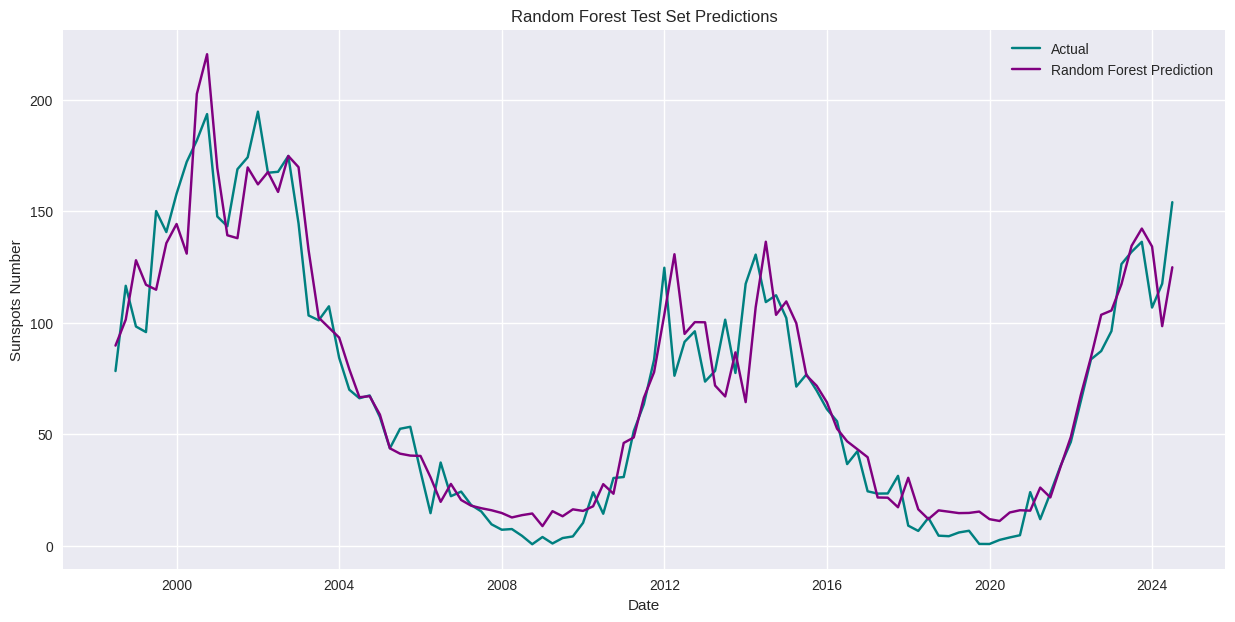

Random Forest Cross-Validation Metrics:
RandomForest: MAE=18.106184263921932, MSE=605.585806330508, RMSE=24.423762582761054, R2=0.7971960730522821

Random Forest Test Set Metrics:
MAE=12.046461045626968, MSE=268.3341835868773, RMSE=16.38090911966968, R2=0.9132082368469094


InvalidParameterError: The 'C' parameter of SVR must be a float in the range (0.0, inf). Got [100, 200] instead.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Assuming df is your dataframe with 'Date' and 'Sunspots_Number' columns

# Convert 'Date' to datetime and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample data to quarterly frequency
df = df.resample('Q').mean()  # Adjust as needed, e.g., 'Q' for quarterly

# Perform seasonal decomposition
result = seasonal_decompose(df['Sunspots_Number'], model='additive', period=4)  # Assuming quarterly periodicity
df['Seasonal'] = result.seasonal

# Split data into train and test sets (considering last 10% as test)
train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Feature engineering
train['Quarter'] = train.index.quarter
train['Year'] = train.index.year
test['Quarter'] = test.index.quarter
test['Year'] = test.index.year

# Define lagged features
lags = [1,2,3,4,5,6]  # lagged values for 1 quarter and 1 year (adjust as needed for quarterly data)

for lag in lags:
    train[f'Sunspots_Number_Lag_{lag}'] = train['Sunspots_Number'].shift(lag)
    test[f'Sunspots_Number_Lag_{lag}'] = test['Sunspots_Number'].shift(lag)

train.dropna(inplace=True)
test.dropna(inplace=True)

# Define evaluation metrics
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    return preds, mae, mse, rmse, r2

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

### Random Forest Implementation ###
rf_params = {
    'n_estimators': 500,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'random_state': 42
}

rf_results = {}
maes, mses, rmses, r2s = [], [], [], []

for train_index, test_index in tscv.split(train):
    train_cv, test_cv = train.iloc[train_index], train.iloc[test_index]
    X_train_cv = train_cv.drop(columns=['Sunspots_Number'])
    y_train_cv = train_cv['Sunspots_Number']
    X_test_cv = test_cv.drop(columns=['Sunspots_Number'])
    y_test_cv = test_cv['Sunspots_Number']

    rf_model = RandomForestRegressor(**rf_params)
    preds, mae, mse, rmse, r2 = evaluate_model(rf_model, X_train_cv, y_train_cv, X_test_cv, y_test_cv)
    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
    r2s.append(r2)

rf_results['RandomForest'] = {
    'MAE': np.mean(maes),
    'MSE': np.mean(mses),
    'RMSE': np.mean(rmses),
    'R2': np.mean(r2s)
}

# Fit the Random Forest model on the entire training data
X_train = train.drop(columns=['Sunspots_Number'])
y_train = train['Sunspots_Number']
X_test = test.drop(columns=['Sunspots_Number'])

final_rf_model = RandomForestRegressor(**rf_params)
final_rf_model.fit(X_train, y_train)
rf_test_preds = final_rf_model.predict(X_test)

# Compute test set metrics
rf_test_mae = mean_absolute_error(test['Sunspots_Number'], rf_test_preds)
rf_test_mse = mean_squared_error(test['Sunspots_Number'], rf_test_preds)
rf_test_rmse = np.sqrt(rf_test_mse)
rf_test_r2 = r2_score(test['Sunspots_Number'], rf_test_preds)

# Plotting the predictions
plt.figure(figsize=(15, 7))
plt.plot(test.index, test['Sunspots_Number'], label='Actual', color='teal')
plt.plot(test.index, rf_test_preds, label='Random Forest Prediction', color='purple')
plt.legend()
plt.title('Random Forest Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.show()

# Print results
print("Random Forest Cross-Validation Metrics:")
for model_name, metrics in rf_results.items():
    print(f"{model_name}: MAE={metrics['MAE']}, MSE={metrics['MSE']}, RMSE={metrics['RMSE']}, R2={metrics['R2']}")

print(f"\nRandom Forest Test Set Metrics:")
print(f"MAE={rf_test_mae}, MSE={rf_test_mse}, RMSE={rf_test_rmse}, R2={rf_test_r2}")

### Support Vector Regression (SVR) Implementation ###
svr_params = {
    'C': [100, 200],
    'epsilon': [0.01, 0.1],
    'kernel': ['linear', 'rbf', 'sigmoid']
}

svr_results = {}
maes, mses, rmses, r2s = [], [], [], []

for train_index, test_index in tscv.split(train):
    train_cv, test_cv = train.iloc[train_index], train.iloc[test_index]
    X_train_cv = train_cv.drop(columns=['Sunspots_Number'])
    y_train_cv = train_cv['Sunspots_Number']
    X_test_cv = test_cv.drop(columns=['Sunspots_Number'])
    y_test_cv = test_cv['Sunspots_Number']

    svr_model = SVR(**svr_params)
    preds, mae, mse, rmse, r2 = evaluate_model(svr_model, X_train_cv, y_train_cv, X_test_cv, y_test_cv)
    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
    r2s.append(r2)

svr_results['SVR'] = {
    'MAE': np.mean(maes),
    'MSE': np.mean(mses),
    'RMSE': np.mean(rmses),
    'R2': np.mean(r2s)
}

# Fit the SVR model on the entire training data
final_svr_model = SVR(**svr_params)
final_svr_model.fit(X_train, y_train)
svr_test_preds = final_svr_model.predict(X_test)

# Compute test set metrics
svr_test_mae = mean_absolute_error(test['Sunspots_Number'], svr_test_preds)
svr_test_mse = mean_squared_error(test['Sunspots_Number'], svr_test_preds)
svr_test_rmse = np.sqrt(svr_test_mse)
svr_test_r2 = r2_score(test['Sunspots_Number'], svr_test_preds)

# Plotting the predictions
plt.figure(figsize=(15, 7))
plt.plot(test.index, test['Sunspots_Number'], label='Actual', color='teal')
plt.plot(test.index, svr_test_preds, label='SVR Prediction', color='purple')
plt.legend()
plt.title('SVR Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.show()

# Print results
# print("SVR Cross-Validation Metrics:")
# for model_name, metrics in svr_results.items():
#     print(f"{model_name}: MAE={metrics['MAE']}, MSE={metrics['MSE']}, RMSE={metrics['RMSE']}, R2={metrics['R2']}")

print(f"\nSVR Test Set Metrics:")
print(f"MAE={svr_test_mae}, MSE={svr_test_mse}, RMSE={svr_test_rmse}, R2={svr_test_r2}")

# Print the best model's metrics
best_model = 'RandomForest' if rf_test_rmse < svr_test_rmse else 'SVR'
print(f"\nBest Model: {best_model}")
print(f"Test Set Metrics for {best_model}:")
if best_model == 'RandomForest':
    print(f"MAE={rf_test_mae}, MSE={rf_test_mse}, RMSE={rf_test_rmse}, R2={rf_test_r2}")
else:
    print(f"MAE={svr_test_mae}, MSE={svr_test_mse}, RMSE={svr_test_rmse}, R2={svr_test_r2}")


<ipython-input-36-6c330f096b8d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Quarter'] = train.index.quarter
<ipython-input-36-6c330f096b8d>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Year'] = train.index.year
<ipython-input-36-6c330f096b8d>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

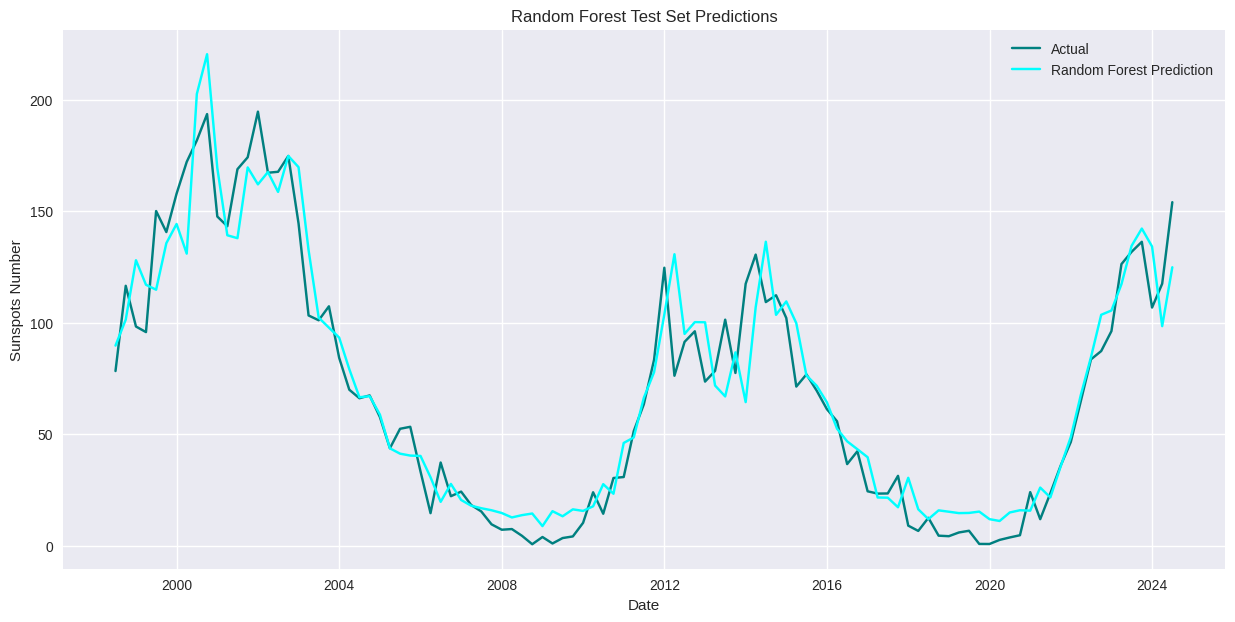

Random Forest Cross-Validation Metrics:
RandomForest: MAE=18.106184263921932, MSE=605.585806330508, RMSE=24.423762582761054, R2=0.7971960730522821

Random Forest Test Set Metrics:
MAE=12.046461045626968, MSE=268.3341835868773, RMSE=16.38090911966968, R2=0.9132082368469094


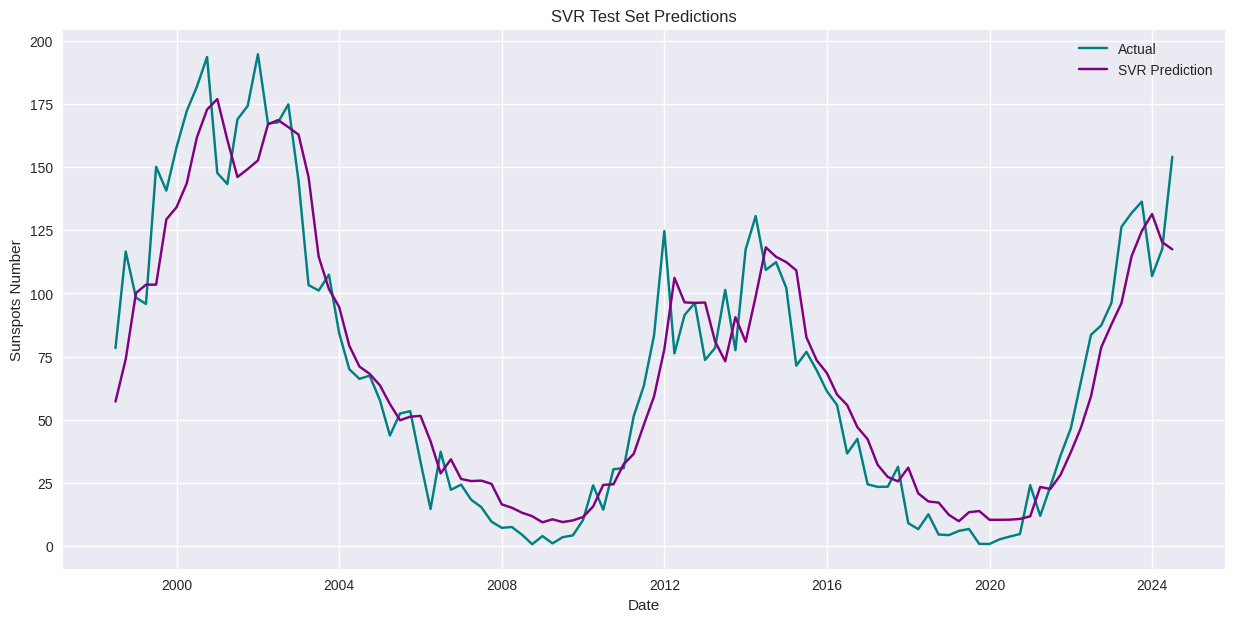


SVR Test Set Metrics:
MAE=13.742326476880232, MSE=314.09662796598917, RMSE=17.72277145273812, R2=0.8984065325662007

Best Model: RandomForest
Test Set Metrics for RandomForest:
MAE=12.046461045626968, MSE=268.3341835868773, RMSE=16.38090911966968, R2=0.9132082368469094


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Assuming df is your dataframe with 'Date' and 'Sunspots_Number' columns

# Convert 'Date' to datetime and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample data to quarterly frequency
df = df.resample('Q').mean()  # Adjust as needed, e.g., 'Q' for quarterly

# Perform seasonal decomposition
result = seasonal_decompose(df['Sunspots_Number'], model='additive', period=4)  # Assuming quarterly periodicity
df['Seasonal'] = result.seasonal

# Split data into train and test sets (considering last 10% as test)
train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Feature engineering
train['Quarter'] = train.index.quarter
train['Year'] = train.index.year
test['Quarter'] = test.index.quarter
test['Year'] = test.index.year

# Define lagged features
lags = [1,2,3,4,5,6]  # lagged values for 1 quarter and 1 year (adjust as needed for quarterly data)

for lag in lags:
    train[f'Sunspots_Number_Lag_{lag}'] = train['Sunspots_Number'].shift(lag)
    test[f'Sunspots_Number_Lag_{lag}'] = test['Sunspots_Number'].shift(lag)

train.dropna(inplace=True)
test.dropna(inplace=True)

# Define evaluation metrics
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    return preds, mae, mse, rmse, r2

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

### Random Forest Implementation ###
rf_params = {
    'n_estimators': 500,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'random_state': 42
}

rf_results = {}
maes, mses, rmses, r2s = [], [], [], []

for train_index, test_index in tscv.split(train):
    train_cv, test_cv = train.iloc[train_index], train.iloc[test_index]
    X_train_cv = train_cv.drop(columns=['Sunspots_Number'])
    y_train_cv = train_cv['Sunspots_Number']
    X_test_cv = test_cv.drop(columns=['Sunspots_Number'])
    y_test_cv = test_cv['Sunspots_Number']

    rf_model = RandomForestRegressor(**rf_params)
    preds, mae, mse, rmse, r2 = evaluate_model(rf_model, X_train_cv, y_train_cv, X_test_cv, y_test_cv)
    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
    r2s.append(r2)

rf_results['RandomForest'] = {
    'MAE': np.mean(maes),
    'MSE': np.mean(mses),
    'RMSE': np.mean(rmses),
    'R2': np.mean(r2s)
}

# Fit the Random Forest model on the entire training data
X_train = train.drop(columns=['Sunspots_Number'])
y_train = train['Sunspots_Number']
X_test = test.drop(columns=['Sunspots_Number'])

final_rf_model = RandomForestRegressor(**rf_params)
final_rf_model.fit(X_train, y_train)
rf_test_preds = final_rf_model.predict(X_test)

# Compute test set metrics
rf_test_mae = mean_absolute_error(test['Sunspots_Number'], rf_test_preds)
rf_test_mse = mean_squared_error(test['Sunspots_Number'], rf_test_preds)
rf_test_rmse = np.sqrt(rf_test_mse)
rf_test_r2 = r2_score(test['Sunspots_Number'], rf_test_preds)

# Plotting the predictions
plt.figure(figsize=(15, 7))
plt.plot(test.index, test['Sunspots_Number'], label='Actual', color='teal')
plt.plot(test.index, rf_test_preds, label='Random Forest Prediction', color='cyan')
plt.legend()
plt.title('Random Forest Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.show()

# Print Random Forest results
print("Random Forest Cross-Validation Metrics:")
for model_name, metrics in rf_results.items():
    print(f"{model_name}: MAE={metrics['MAE']}, MSE={metrics['MSE']}, RMSE={metrics['RMSE']}, R2={metrics['R2']}")

print(f"\nRandom Forest Test Set Metrics:")
print(f"MAE={rf_test_mae}, MSE={rf_test_mse}, RMSE={rf_test_rmse}, R2={rf_test_r2}")

### Support Vector Regression (SVR) Implementation ###
svr_param_grid = {
    'C': [100, 200],
    'epsilon': [0.01, 0.1],
    'kernel': ['linear', 'rbf', 'sigmoid']
}

# Initialize the SVR model
svr_model = SVR()

# Initialize GridSearchCV with SVR model and parameter grid
grid_search = GridSearchCV(estimator=svr_model, param_grid=svr_param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_svr_model = grid_search.best_estimator_

# Evaluate the best SVR model using cross-validation
svr_results = {}
maes, mses, rmses, r2s = [], [], [], []

for train_index, test_index in tscv.split(train):
    train_cv, test_cv = train.iloc[train_index], train.iloc[test_index]
    X_train_cv = train_cv.drop(columns=['Sunspots_Number'])
    y_train_cv = train_cv['Sunspots_Number']
    X_test_cv = test_cv.drop(columns=['Sunspots_Number'])
    y_test_cv = test_cv['Sunspots_Number']

    # Use the best SVR model found by GridSearchCV
    preds = best_svr_model.predict(X_test_cv)
    mae = mean_absolute_error(y_test_cv, preds)
    mse = mean_squared_error(y_test_cv, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_cv, preds)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
    r2s.append(r2)

svr_results['SVR'] = {
    'MAE': np.mean(maes),
    'MSE': np.mean(mses),
    'RMSE': np.mean(rmses),
    'R2': np.mean(r2s)
}

# Fit the best SVR model on the entire training data
best_svr_model.fit(X_train, y_train)
svr_test_preds = best_svr_model.predict(X_test)

# Compute test set metrics
svr_test_mae = mean_absolute_error(test['Sunspots_Number'], svr_test_preds)
svr_test_mse = mean_squared_error(test['Sunspots_Number'], svr_test_preds)
svr_test_rmse = np.sqrt(svr_test_mse)
svr_test_r2 = r2_score(test['Sunspots_Number'], svr_test_preds)

# Plotting the predictions
plt.figure(figsize=(15, 7))
plt.plot(test.index, test['Sunspots_Number'], label='Actual', color='teal')
plt.plot(test.index, svr_test_preds, label='SVR Prediction', color='purple')
plt.legend()
plt.title('SVR Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.show()

# Print SVR results
print(f"\nSVR Test Set Metrics:")
print(f"MAE={svr_test_mae}, MSE={svr_test_mse}, RMSE={svr_test_rmse}, R2={svr_test_r2}")

# Print the best model's metrics
best_model = 'RandomForest' if rf_test_rmse < svr_test_rmse else 'SVR'
print(f"\nBest Model: {best_model}")
print(f"Test Set Metrics for {best_model}:")
if best_model == 'RandomForest':
    print(f"MAE={rf_test_mae}, MSE={rf_test_mse}, RMSE={rf_test_rmse}, R2={rf_test_r2}")
else:
    print(f"MAE={svr_test_mae}, MSE={svr_test_mse}, RMSE={svr_test_rmse}, R2={svr_test_r2}")


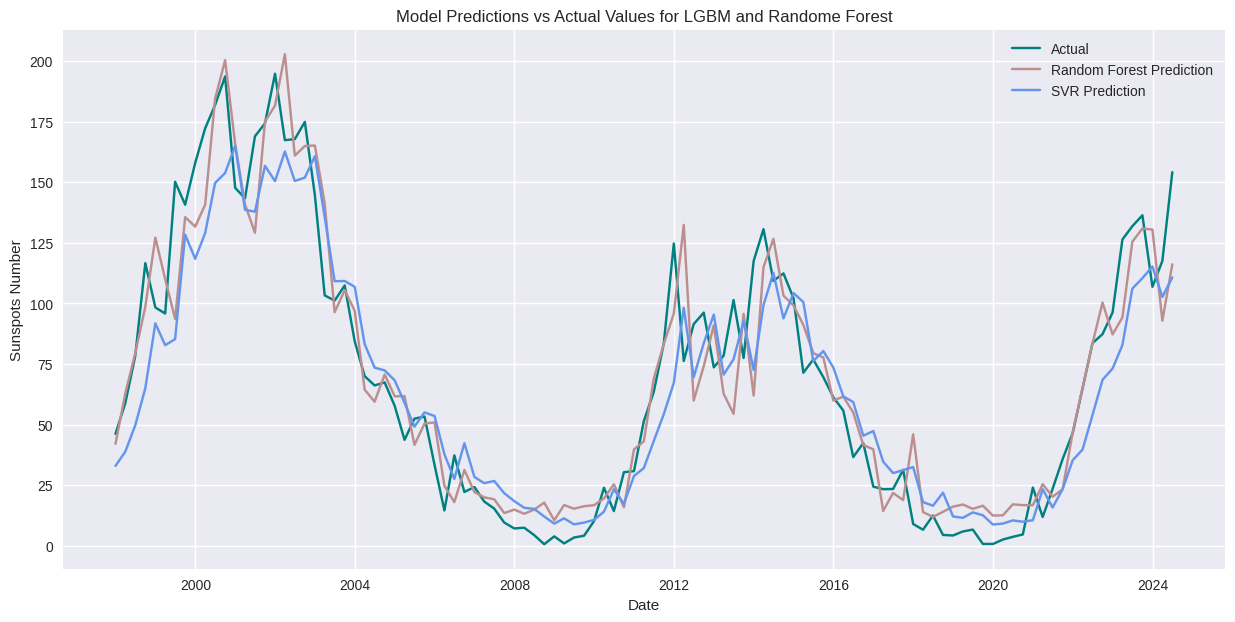

In [ ]:
import matplotlib.pyplot as plt

# Assuming `test.index`, `test['Sunspots_Number']`, `rf_test_preds`, and `svr_test_preds` are already defined

plt.figure(figsize=(15, 7))

# Plot actual values
plt.plot(test.index, test['Sunspots_Number'], label='Actual', color='teal')

# Plot Random Forest predictions
plt.plot(test.index, rf_test_preds, label='Random Forest Prediction', color='rosybrown')

# Plot SVR predictions
plt.plot(test.index, svr_test_preds, label='SVR Prediction', color='cornflowerblue')

# Add legend
plt.legend()

# Add title and labels
plt.title('Model Predictions vs Actual Values for LGBM and Randome Forest')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')

# Show plot
plt.show()

###Grid Search

<ipython-input-18-607275e28714>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Quarter'] = train.index.quarter
<ipython-input-18-607275e28714>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Year'] = train.index.year
<ipython-input-18-607275e28714>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

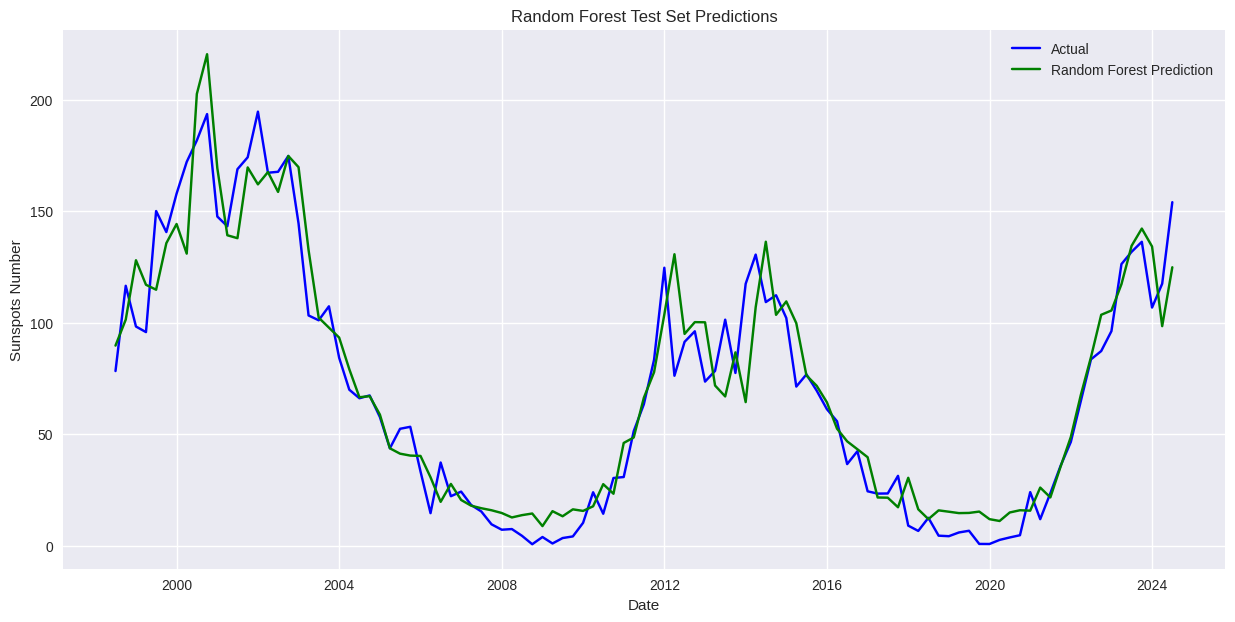

Best Random Forest Parameters:
{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}

Random Forest Test Set Metrics:
MAE=12.046461045626968, MSE=268.3341835868773, RMSE=16.38090911966968, R2=0.9132082368469094


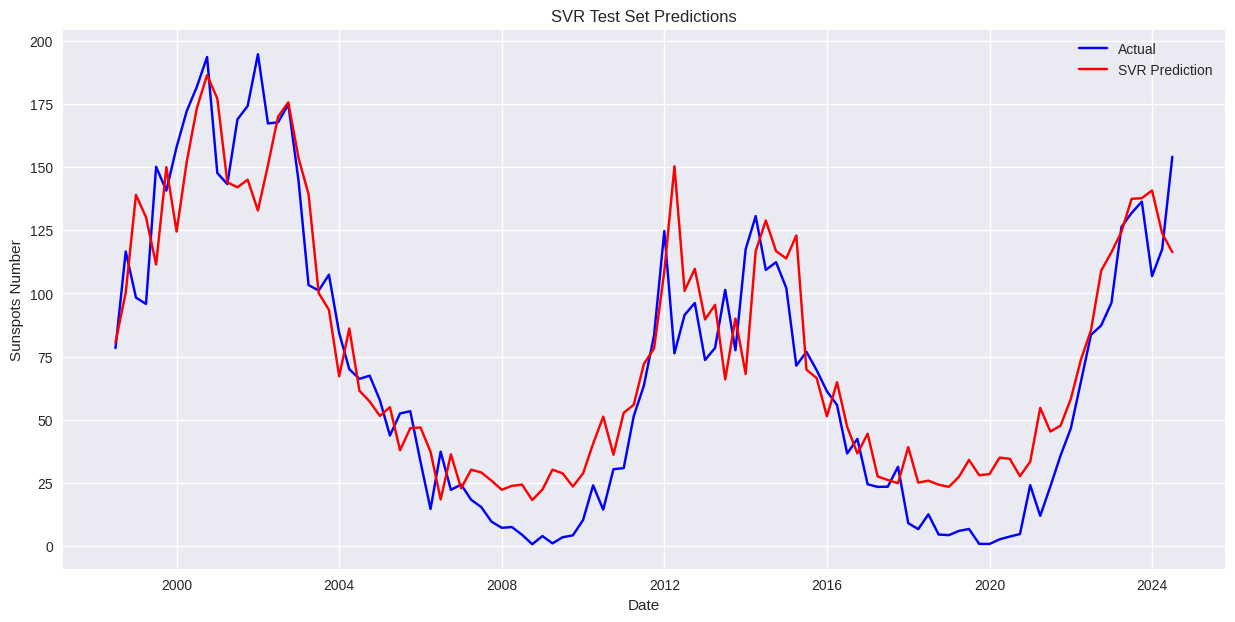

Best SVR Parameters:
{'C': 100, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'}

SVR Test Set Metrics:
MAE=17.774981289600497, MSE=492.6845549436443, RMSE=22.196498709112756, R2=0.8406428855606087

Best Model: RandomForest
Test Set Metrics for RandomForest:
MAE=12.046461045626968, MSE=268.3341835868773, RMSE=16.38090911966968, R2=0.9132082368469094


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Assuming df is your dataframe with 'Date' and 'Sunspots_Number' columns

# Convert 'Date' to datetime and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample data to quarterly frequency
df = df.resample('Q').mean()  # Adjust as needed, e.g., 'Q' for quarterly

# Perform seasonal decomposition
result = seasonal_decompose(df['Sunspots_Number'], model='additive', period=4)  # Assuming quarterly periodicity
df['Seasonal'] = result.seasonal

# Split data into train and test sets (considering last 10% as test)
train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Feature engineering
train['Quarter'] = train.index.quarter
train['Year'] = train.index.year
test['Quarter'] = test.index.quarter
test['Year'] = test.index.year

# Define lagged features
lags = [1,2,3,4,5,6]  # lagged values for 1 quarter and 1 year (adjust as needed for quarterly data)

for lag in lags:
    train[f'Sunspots_Number_Lag_{lag}'] = train['Sunspots_Number'].shift(lag)
    test[f'Sunspots_Number_Lag_{lag}'] = test['Sunspots_Number'].shift(lag)

train.dropna(inplace=True)
test.dropna(inplace=True)

# Scaling features
scaler = StandardScaler()
X_train = train.drop(columns=['Sunspots_Number'])
y_train = train['Sunspots_Number']
X_test = test.drop(columns=['Sunspots_Number'])
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define evaluation metrics
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    return preds, mae, mse, rmse, r2

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define the parameter grid for RandomForestRegressor
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [2],
    'max_features': ['auto'],
    'bootstrap': [True]
}

# Define the parameter grid for SVR
svr_param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10, 100, 200],
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'gamma': ['scale', 'auto']
}

# Create scorers
scorer = make_scorer(mean_squared_error, greater_is_better=False)

### Random Forest Grid Search ###
rf_model = RandomForestRegressor(random_state=42)
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=tscv, scoring=scorer, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Best RF model
best_rf_model = rf_grid_search.best_estimator_

# Fit the best RF model on the entire training data
best_rf_model.fit(X_train, y_train)
rf_test_preds = best_rf_model.predict(X_test)

# Compute test set metrics for RF
rf_test_mae = mean_absolute_error(test['Sunspots_Number'], rf_test_preds)
rf_test_mse = mean_squared_error(test['Sunspots_Number'], rf_test_preds)
rf_test_rmse = np.sqrt(rf_test_mse)
rf_test_r2 = r2_score(test['Sunspots_Number'], rf_test_preds)
rf_test_mape = mean_absolute_percentage_error(test['Sunspots_Number'], rf_test_preds)

# Plotting the predictions
plt.figure(figsize=(15, 7))
plt.plot(test.index, test['Sunspots_Number'], label='Actual', color='blue')
plt.plot(test.index, rf_test_preds, label='Random Forest Prediction', color='green')
plt.legend()
plt.title('Random Forest Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.show()

# Print results for RF
print("Best Random Forest Parameters:")
print(rf_grid_search.best_params_)
print(f"\nRandom Forest Test Set Metrics:")
print(f"MAE={rf_test_mae}, MSE={rf_test_mse}, RMSE={rf_test_rmse}, R2={rf_test_r2}")

### SVR Grid Search ###
svr_model = SVR()
svr_grid_search = GridSearchCV(estimator=svr_model, param_grid=svr_param_grid, cv=tscv, scoring=scorer, n_jobs=-1)
svr_grid_search.fit(X_train_scaled, y_train)

# Best SVR model
best_svr_model = svr_grid_search.best_estimator_

# Fit the best SVR model on the entire training data
best_svr_model.fit(X_train_scaled, y_train)
svr_test_preds = best_svr_model.predict(X_test_scaled)

# Compute test set metrics for SVR
svr_test_mae = mean_absolute_error(test['Sunspots_Number'], svr_test_preds)
svr_test_mse = mean_squared_error(test['Sunspots_Number'], svr_test_preds)
svr_test_rmse = np.sqrt(svr_test_mse)
svr_test_r2 = r2_score(test['Sunspots_Number'], svr_test_preds)
svr_test_mape = mean_absolute_percentage_error(test['Sunspots_Number'], svr_test_preds)

# Plotting the predictions
plt.figure(figsize=(15, 7))
plt.plot(test.index, test['Sunspots_Number'], label='Actual', color='blue')
plt.plot(test.index, svr_test_preds, label='SVR Prediction', color='red')
plt.legend()
plt.title('SVR Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.show()

# Print results for SVR
print("Best SVR Parameters:")
print(svr_grid_search.best_params_)
print(f"\nSVR Test Set Metrics:")
print(f"MAE={svr_test_mae}, MSE={svr_test_mse}, RMSE={svr_test_rmse}, R2={svr_test_r2}")

# Print the best model's metrics
best_model = 'RandomForest' if rf_test_rmse < svr_test_rmse else 'SVR'
print(f"\nBest Model: {best_model}")
print(f"Test Set Metrics for {best_model}:")
if best_model == 'RandomForest':
    print(f"MAE={rf_test_mae}, MSE={rf_test_mse}, RMSE={rf_test_rmse}, R2={rf_test_r2}")
else:
    print(f"MAE={svr_test_mae}, MSE={svr_test_mse}, RMSE={svr_test_rmse}, R2={svr_test_r2}")


<ipython-input-20-e1e292a62299>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Quarter'] = train.index.quarter
<ipython-input-20-e1e292a62299>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Year'] = train.index.year
<ipython-input-20-e1e292a62299>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

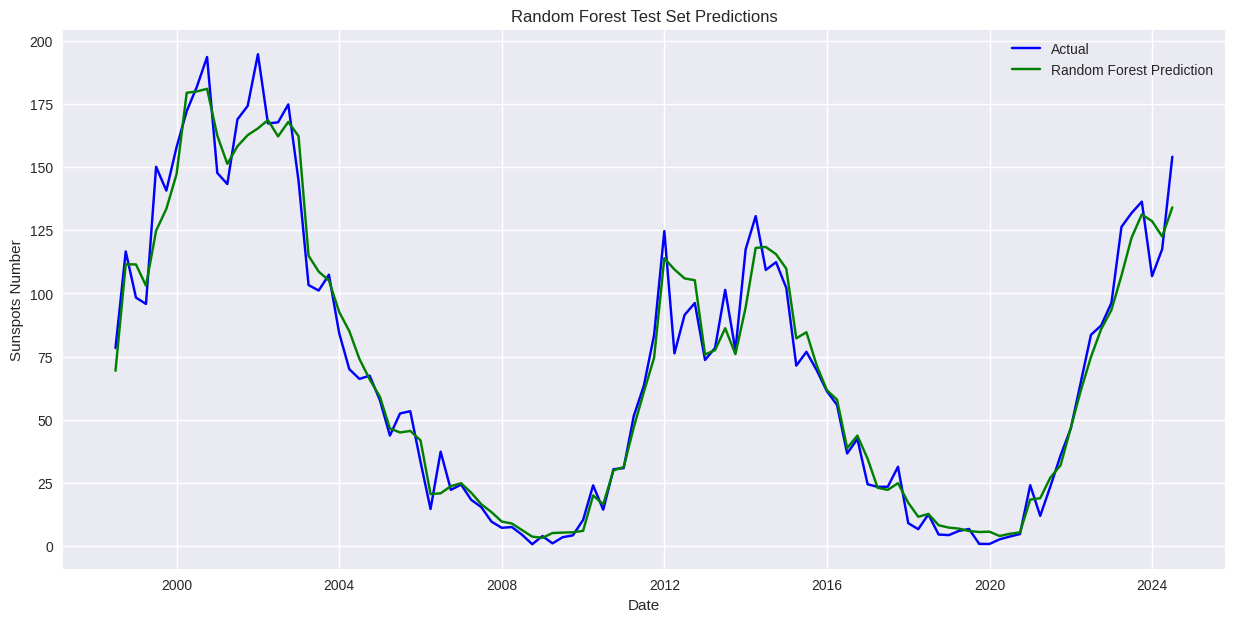

Best Random Forest Parameters:
{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}

Random Forest Test Set Metrics:
MAE=6.689488128670642, MSE=86.69155114149875, RMSE=9.310829777280796, R2=0.9719599177657104


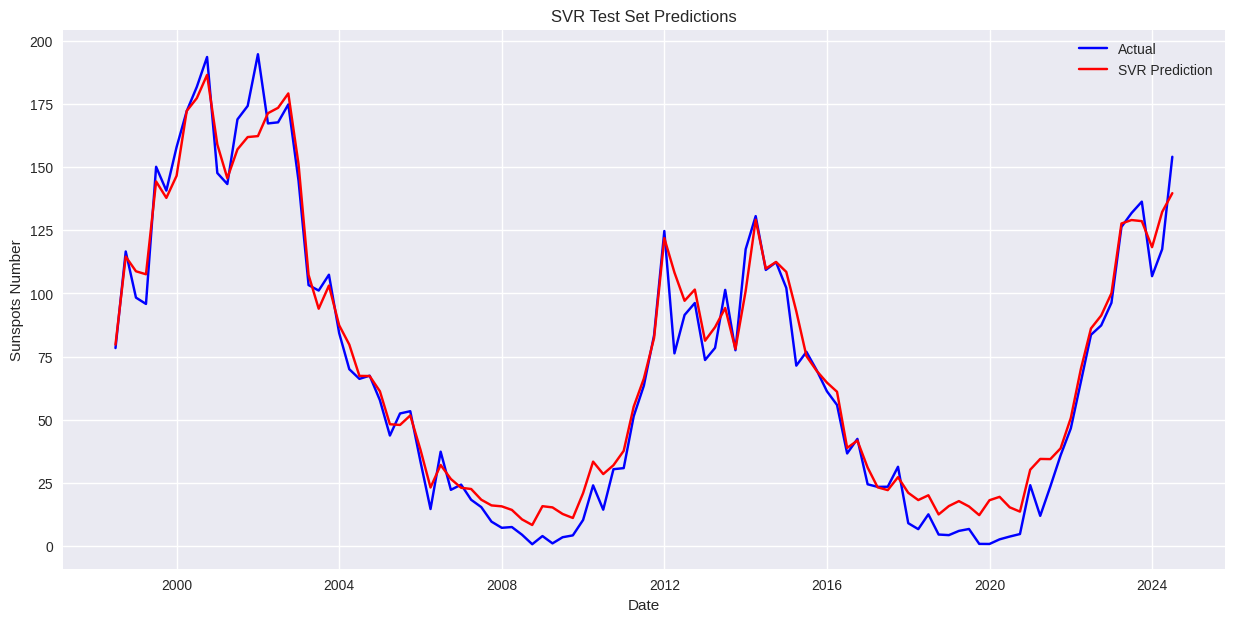

Best SVR Parameters:
{'C': 200, 'epsilon': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}

SVR Test Set Metrics:
MAE=7.086284590949866, MSE=84.85822485374236, RMSE=9.211852411634826, R2=0.972552900809549


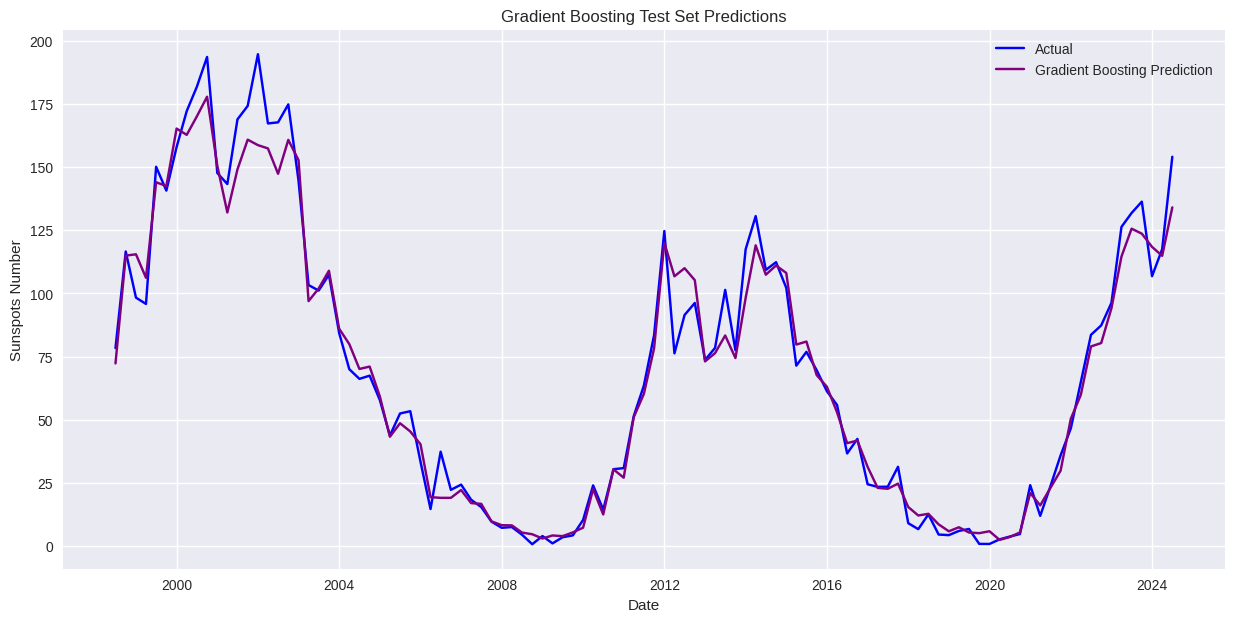

Best Gradient Boosting Parameters:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

Gradient Boosting Test Set Metrics:
MAE=6.011306220357652, MSE=78.37279155394923, RMSE=8.85284087476722, R2=0.9746505917685488


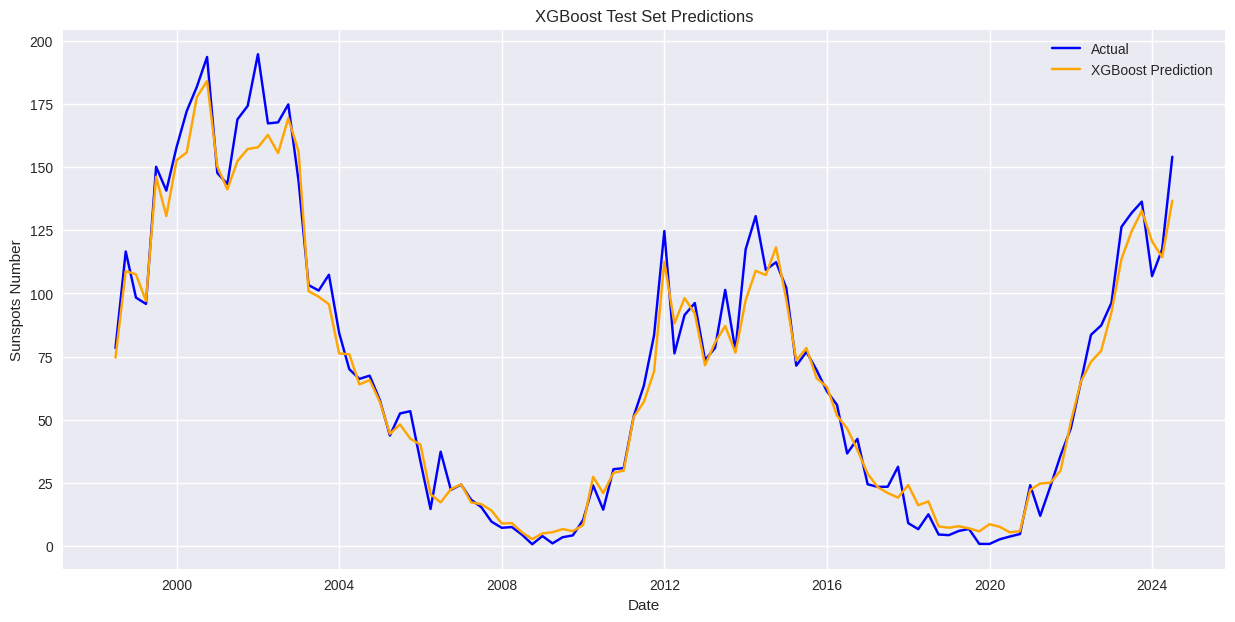

Best XGBoost Parameters:
{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

XGBoost Test Set Metrics:
MAE=6.126835350157724, MSE=73.1536669298604, RMSE=8.552991694714803, R2=0.9763386995682535

Best Model: XGBoost
Test Set Metrics for XGBoost:
MAE=6.126835350157724, MSE=73.1536669298604, RMSE=8.552991694714803, R2=0.9763386995682535


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# Assuming df is your dataframe with 'Date' and 'Sunspots_Number' columns

# Convert 'Date' to datetime and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample data to quarterly frequency
df = df.resample('Q').mean()  # Adjust as needed, e.g., 'Q' for quarterly

# Perform seasonal decomposition
result = seasonal_decompose(df['Sunspots_Number'], model='additive', period=4)  # Assuming quarterly periodicity
df['Seasonal'] = result.seasonal

# Split data into train and test sets (considering last 10% as test)
train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Feature engineering
train['Quarter'] = train.index.quarter
train['Year'] = train.index.year
test['Quarter'] = test.index.quarter
test['Year'] = test.index.year

# Adding sine and cosine transformations for seasonality
train['Sin_Quarter'] = np.sin(2 * np.pi * train['Quarter'] / 4)
train['Cos_Quarter'] = np.cos(2 * np.pi * train['Quarter'] / 4)
test['Sin_Quarter'] = np.sin(2 * np.pi * test['Quarter'] / 4)
test['Cos_Quarter'] = np.cos(2 * np.pi * test['Quarter'] / 4)

# Define lagged features
lags = [1, 2, 3, 4, 5, 6]  # lagged values for 1 quarter and 1 year (adjust as needed for quarterly data)

for lag in lags:
    train[f'Sunspots_Number_Lag_{lag}'] = train['Sunspots_Number'].shift(lag)
    test[f'Sunspots_Number_Lag_{lag}'] = test['Sunspots_Number'].shift(lag)

# Adding rolling mean and rolling std
train['Rolling_Mean'] = train['Sunspots_Number'].rolling(window=4).mean()
train['Rolling_Std'] = train['Sunspots_Number'].rolling(window=4).std()
test['Rolling_Mean'] = test['Sunspots_Number'].rolling(window=4).mean()
test['Rolling_Std'] = test['Sunspots_Number'].rolling(window=4).std()

train.dropna(inplace=True)
test.dropna(inplace=True)

# Scaling features
scaler = StandardScaler()
X_train = train.drop(columns=['Sunspots_Number'])
y_train = train['Sunspots_Number']
X_test = test.drop(columns=['Sunspots_Number'])
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define evaluation metrics
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    return preds, mae, mse, rmse, r2

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define the parameter grid for RandomForestRegressor
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [2],
    'max_features': ['auto'],
    'bootstrap': [True]
}

# Define the parameter grid for SVR
svr_param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10, 100, 200],
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'gamma': ['scale', 'auto']
}

# Define the parameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'max_depth': [3, 5, 7]
}

# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Create scorers
scorer = make_scorer(mean_squared_error, greater_is_better=False)

### Random Forest Grid Search ###
rf_model = RandomForestRegressor(random_state=42)
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=tscv, scoring=scorer, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Best RF model
best_rf_model = rf_grid_search.best_estimator_

# Fit the best RF model on the entire training data
best_rf_model.fit(X_train, y_train)
rf_test_preds = best_rf_model.predict(X_test)

# Compute test set metrics for RF
rf_test_mae = mean_absolute_error(test['Sunspots_Number'], rf_test_preds)
rf_test_mse = mean_squared_error(test['Sunspots_Number'], rf_test_preds)
rf_test_rmse = np.sqrt(rf_test_mse)
rf_test_r2 = r2_score(test['Sunspots_Number'], rf_test_preds)
rf_test_mape = mean_absolute_percentage_error(test['Sunspots_Number'], rf_test_preds)

# Plotting the predictions
plt.figure(figsize=(15, 7))
plt.plot(test.index, test['Sunspots_Number'], label='Actual', color='blue')
plt.plot(test.index, rf_test_preds, label='Random Forest Prediction', color='green')
plt.legend()
plt.title('Random Forest Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.show()

# Print results for RF
print("Best Random Forest Parameters:")
print(rf_grid_search.best_params_)
print(f"\nRandom Forest Test Set Metrics:")
print(f"MAE={rf_test_mae}, MSE={rf_test_mse}, RMSE={rf_test_rmse}, R2={rf_test_r2}")

### SVR Grid Search ###
svr_model = SVR()
svr_grid_search = GridSearchCV(estimator=svr_model, param_grid=svr_param_grid, cv=tscv, scoring=scorer, n_jobs=-1)
svr_grid_search.fit(X_train_scaled, y_train)

# Best SVR model
best_svr_model = svr_grid_search.best_estimator_

# Fit the best SVR model on the entire training data
best_svr_model.fit(X_train_scaled, y_train)
svr_test_preds = best_svr_model.predict(X_test_scaled)

# Compute test set metrics for SVR
svr_test_mae = mean_absolute_error(test['Sunspots_Number'], svr_test_preds)
svr_test_mse = mean_squared_error(test['Sunspots_Number'], svr_test_preds)
svr_test_rmse = np.sqrt(svr_test_mse)
svr_test_r2 = r2_score(test['Sunspots_Number'], svr_test_preds)
svr_test_mape = mean_absolute_percentage_error(test['Sunspots_Number'], svr_test_preds)

# Plotting the predictions
plt.figure(figsize=(15, 7))
plt.plot(test.index, test['Sunspots_Number'], label='Actual', color='blue')
plt.plot(test.index, svr_test_preds, label='SVR Prediction', color='red')
plt.legend()
plt.title('SVR Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.show()

# Print results for SVR
print("Best SVR Parameters:")
print(svr_grid_search.best_params_)
print(f"\nSVR Test Set Metrics:")
print(f"MAE={svr_test_mae}, MSE={svr_test_mse}, RMSE={svr_test_rmse}, R2={svr_test_r2}")

### Gradient Boosting Grid Search ###
gb_model = GradientBoostingRegressor(random_state=42)
gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, cv=tscv, scoring=scorer, n_jobs=-1)
gb_grid_search.fit(X_train, y_train)

# Best GB model
best_gb_model = gb_grid_search.best_estimator_

# Fit the best GB model on the entire training data
best_gb_model.fit(X_train, y_train)
gb_test_preds = best_gb_model.predict(X_test)

# Compute test set metrics for GB
gb_test_mae = mean_absolute_error(test['Sunspots_Number'], gb_test_preds)
gb_test_mse = mean_squared_error(test['Sunspots_Number'], gb_test_preds)
gb_test_rmse = np.sqrt(gb_test_mse)
gb_test_r2 = r2_score(test['Sunspots_Number'], gb_test_preds)
gb_test_mape = mean_absolute_percentage_error(test['Sunspots_Number'], gb_test_preds)

# Plotting the predictions
plt.figure(figsize=(15, 7))
plt.plot(test.index, test['Sunspots_Number'], label='Actual', color='blue')
plt.plot(test.index, gb_test_preds, label='Gradient Boosting Prediction', color='purple')
plt.legend()
plt.title('Gradient Boosting Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.show()

# Print results for GB
print("Best Gradient Boosting Parameters:")
print(gb_grid_search.best_params_)
print(f"\nGradient Boosting Test Set Metrics:")
print(f"MAE={gb_test_mae}, MSE={gb_test_mse}, RMSE={gb_test_rmse}, R2={gb_test_r2}")

### XGBoost Grid Search ###
xgb_model = XGBRegressor(random_state=42)
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=tscv, scoring=scorer, n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

# Best XGB model
best_xgb_model = xgb_grid_search.best_estimator_

# Fit the best XGB model on the entire training data
best_xgb_model.fit(X_train, y_train)
xgb_test_preds = best_xgb_model.predict(X_test)

# Compute test set metrics for XGB
xgb_test_mae = mean_absolute_error(test['Sunspots_Number'], xgb_test_preds)
xgb_test_mse = mean_squared_error(test['Sunspots_Number'], xgb_test_preds)
xgb_test_rmse = np.sqrt(xgb_test_mse)
xgb_test_r2 = r2_score(test['Sunspots_Number'], xgb_test_preds)
xgb_test_mape = mean_absolute_percentage_error(test['Sunspots_Number'], xgb_test_preds)

# Plotting the predictions
plt.figure(figsize=(15, 7))
plt.plot(test.index, test['Sunspots_Number'], label='Actual', color='blue')
plt.plot(test.index, xgb_test_preds, label='XGBoost Prediction', color='orange')
plt.legend()
plt.title('XGBoost Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.show()

# Print results for XGB
print("Best XGBoost Parameters:")
print(xgb_grid_search.best_params_)
print(f"\nXGBoost Test Set Metrics:")
print(f"MAE={xgb_test_mae}, MSE={xgb_test_mse}, RMSE={xgb_test_rmse}, R2={xgb_test_r2}")

# Compare and print the best model's metrics
models_rmse = {
    'RandomForest': rf_test_rmse,
    'SVR': svr_test_rmse,
    'GradientBoosting': gb_test_rmse,
    'XGBoost': xgb_test_rmse
}

best_model_name = min(models_rmse, key=models_rmse.get)
print(f"\nBest Model: {best_model_name}")
print(f"Test Set Metrics for {best_model_name}:")
if best_model_name == 'RandomForest':
    print(f"MAE={rf_test_mae}, MSE={rf_test_mse}, RMSE={rf_test_rmse}, R2={rf_test_r2}")
elif best_model_name == 'SVR':
    print(f"MAE={svr_test_mae}, MSE={svr_test_mse}, RMSE={svr_test_rmse}, R2={svr_test_r2}")
elif best_model_name == 'GradientBoosting':
    print(f"MAE={gb_test_mae}, MSE={gb_test_mse}, RMSE={gb_test_rmse}, R2={gb_test_r2}")
else:
    print(f"MAE={xgb_test_mae}, MSE={xgb_test_mse}, RMSE={xgb_test_rmse}, R2={xgb_test_r2}")


#SVR with Rolling mean

<ipython-input-22-b1911d9f0548>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Quarter'] = train.index.quarter
<ipython-input-22-b1911d9f0548>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Year'] = train.index.year
<ipython-input-22-b1911d9f0548>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

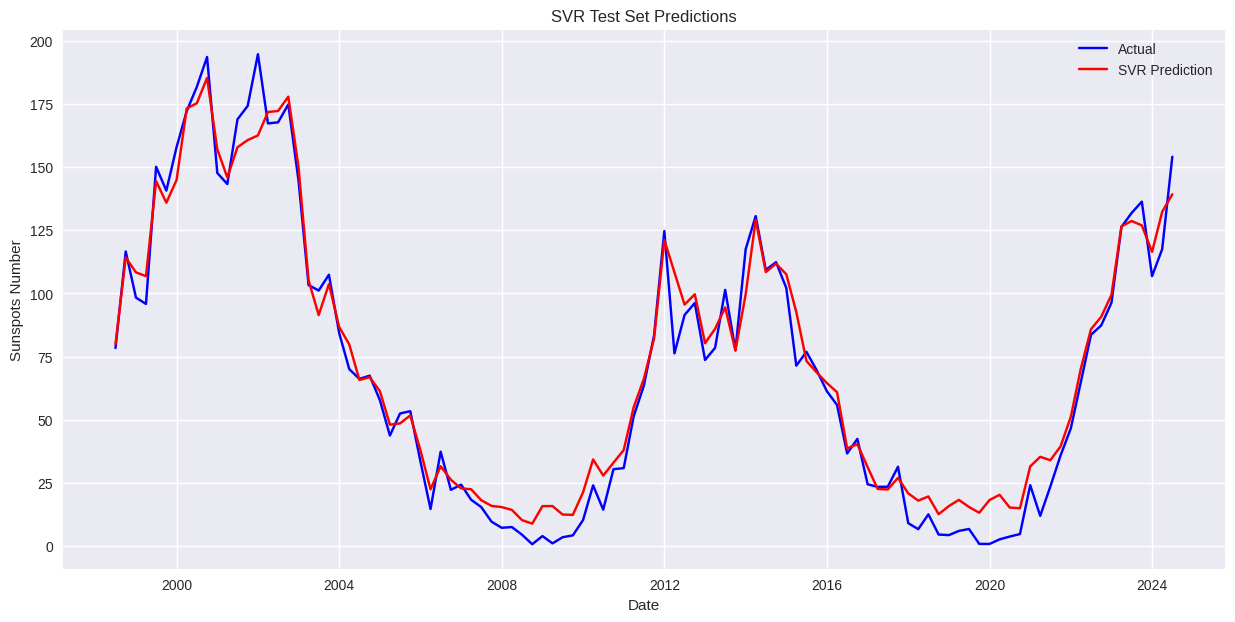

Best SVR Parameters:
{'C': 200, 'epsilon': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}

SVR Test Set Metrics:
MAE=7.150307437064325, MSE=86.26071432031662, RMSE=9.287664632205269, R2=0.9720992704446789, MAPE=1.036456174975774


In [ ]:
# Assuming df is your dataframe with 'Date' and 'Sunspots_Number' columns

# Convert 'Date' to datetime and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample data to quarterly frequency
df = df.resample('Q').mean()  # Adjust as needed, e.g., 'Q' for quarterly

# Perform seasonal decomposition
result = seasonal_decompose(df['Sunspots_Number'], model='additive', period=4)  # Assuming quarterly periodicity
df['Seasonal'] = result.seasonal

# Split data into train and test sets (considering last 10% as test)
train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Feature engineering
train['Quarter'] = train.index.quarter
train['Year'] = train.index.year
test['Quarter'] = test.index.quarter
test['Year'] = test.index.year

# Define lagged features
lags = [1, 2, 3, 4, 5, 6]  # Lagged values for 1 quarter and 1 year

for lag in lags:
    train[f'Sunspots_Number_Lag_{lag}'] = train['Sunspots_Number'].shift(lag)
    test[f'Sunspots_Number_Lag_{lag}'] = test['Sunspots_Number'].shift(lag)

# Adding rolling mean and rolling std features (e.g., 4 quarters)
window_size = 4
train['Rolling_Mean'] = train['Sunspots_Number'].rolling(window=window_size).mean()
train['Rolling_Std'] = train['Sunspots_Number'].rolling(window=window_size).std()
test['Rolling_Mean'] = test['Sunspots_Number'].rolling(window=window_size).mean()
test['Rolling_Std'] = test['Sunspots_Number'].rolling(window=window_size).std()

# Dropping NaN values due to lagging and rolling window
train.dropna(inplace=True)
test.dropna(inplace=True)

# Scaling features
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.drop(columns=['Sunspots_Number']))
test_scaled = scaler.transform(test.drop(columns=['Sunspots_Number']))

X_train = pd.DataFrame(train_scaled, columns=train.drop(columns=['Sunspots_Number']).columns, index=train.index)
y_train = train['Sunspots_Number']
X_test = pd.DataFrame(test_scaled, columns=test.drop(columns=['Sunspots_Number']).columns, index=test.index)
y_test = test['Sunspots_Number']

# Define evaluation metrics
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    mape = mean_absolute_percentage_error(y_test, preds)
    return preds, mae, mse, rmse, r2, mape

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define the parameter grid for SVR
svr_param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10, 100, 200],
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'gamma': ['scale', 'auto']
}

# Create scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# SVR Grid Search
svr_model = SVR()
svr_grid_search = GridSearchCV(estimator=svr_model, param_grid=svr_param_grid, cv=tscv, scoring=scorer, n_jobs=-1)
svr_grid_search.fit(X_train, y_train)

# Best SVR model
best_svr_model = svr_grid_search.best_estimator_

# Fit the best SVR model on the entire training data
best_svr_model.fit(X_train, y_train)
svr_test_preds = best_svr_model.predict(X_test)

# Compute test set metrics for SVR
svr_test_mae = mean_absolute_error(y_test, svr_test_preds)
svr_test_mse = mean_squared_error(y_test, svr_test_preds)
svr_test_rmse = np.sqrt(svr_test_mse)
svr_test_r2 = r2_score(y_test, svr_test_preds)
svr_test_mape = mean_absolute_percentage_error(y_test, svr_test_preds)

# Plotting the predictions
plt.figure(figsize=(15, 7))
plt.plot(test.index, test['Sunspots_Number'], label='Actual', color='blue')
plt.plot(test.index, svr_test_preds, label='SVR Prediction', color='red')
plt.legend()
plt.title('SVR Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.show()

# Print results for SVR
print("Best SVR Parameters:")
print(svr_grid_search.best_params_)
print(f"\nSVR Test Set Metrics:")
print(f"MAE={svr_test_mae}, MSE={svr_test_mse}, RMSE={svr_test_rmse}, R2={svr_test_r2}, MAPE={svr_test_mape}")


#ML Models with rolling mean

<ipython-input-24-4b74fd9d259b>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Quarter'] = data.index.quarter
<ipython-input-24-4b74fd9d259b>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Year'] = data.index.year
<ipython-input-24-4b74fd9d259b>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

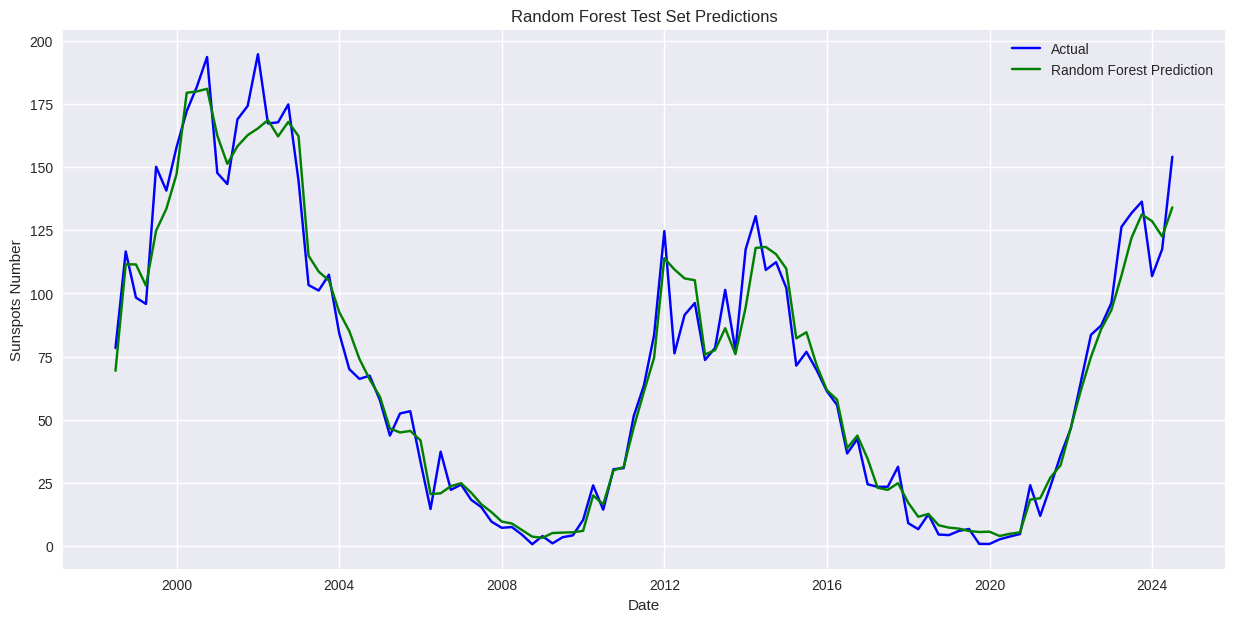

Best Random Forest Parameters:
{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}

Random Forest Test Set Metrics:
MAE=6.689488128670642, MSE=86.69155114149875, RMSE=9.310829777280796, R2=0.9719599177657104


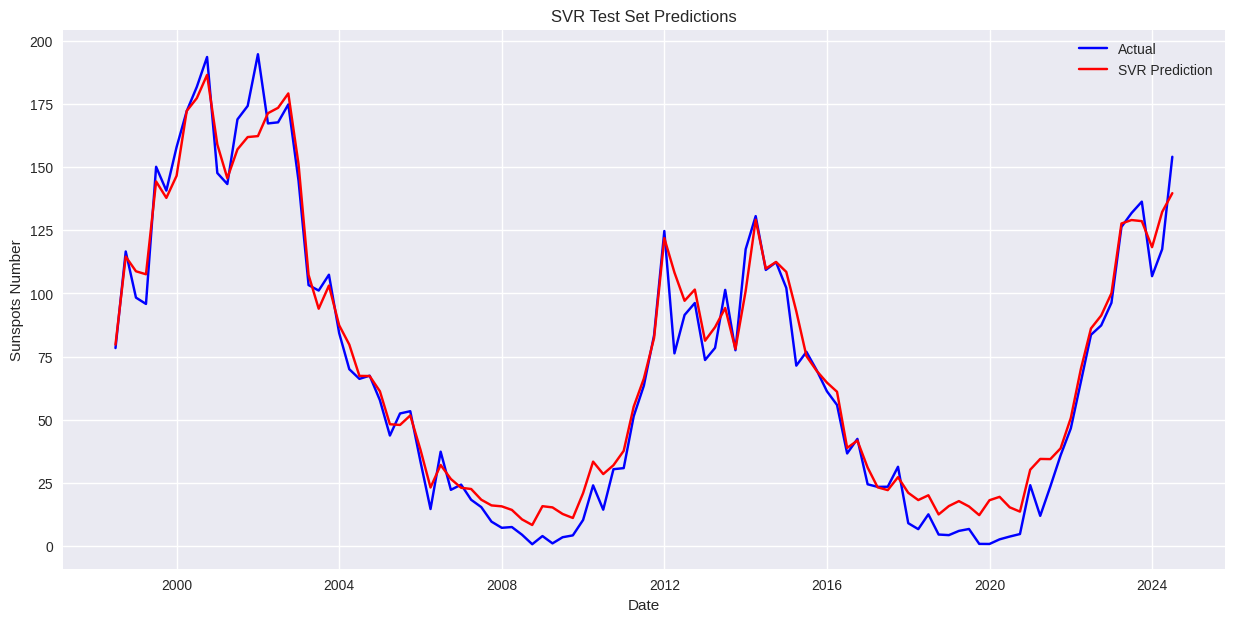

Best SVR Parameters:
{'C': 200, 'epsilon': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}

SVR Test Set Metrics:
MAE=7.086284590949866, MSE=84.85822485374236, RMSE=9.211852411634826, R2=0.972552900809549


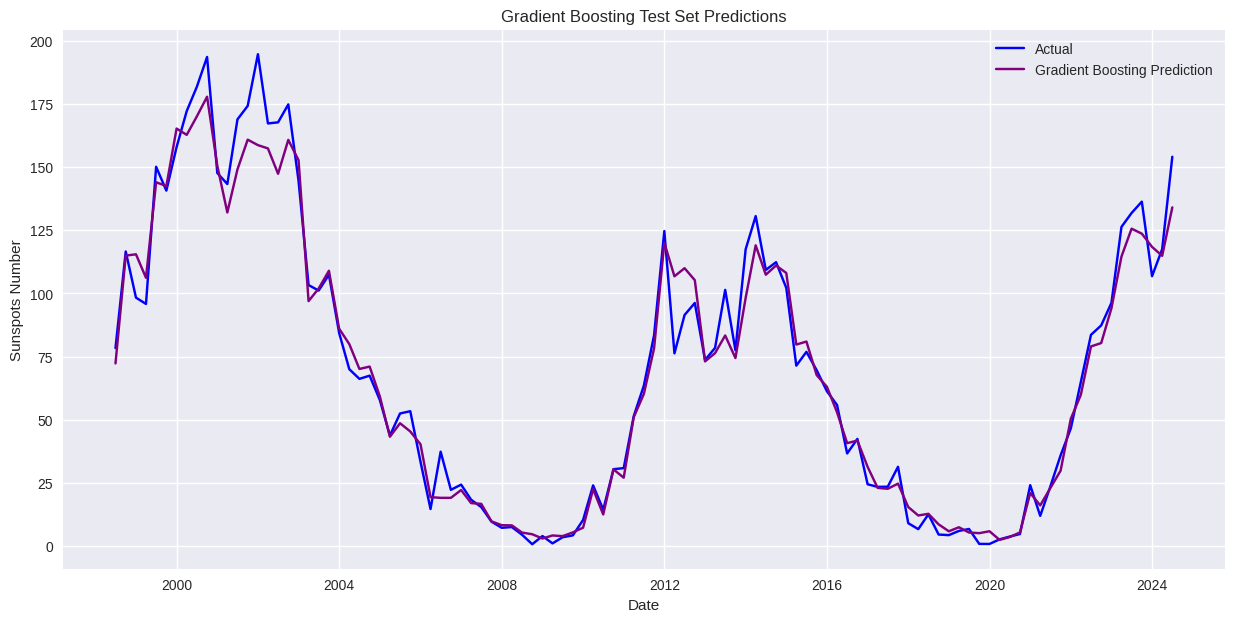

Best Gradient Boosting Parameters:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

Gradient Boosting Test Set Metrics:
MAE=6.011306220357652, MSE=78.37279155394923, RMSE=8.85284087476722, R2=0.9746505917685488


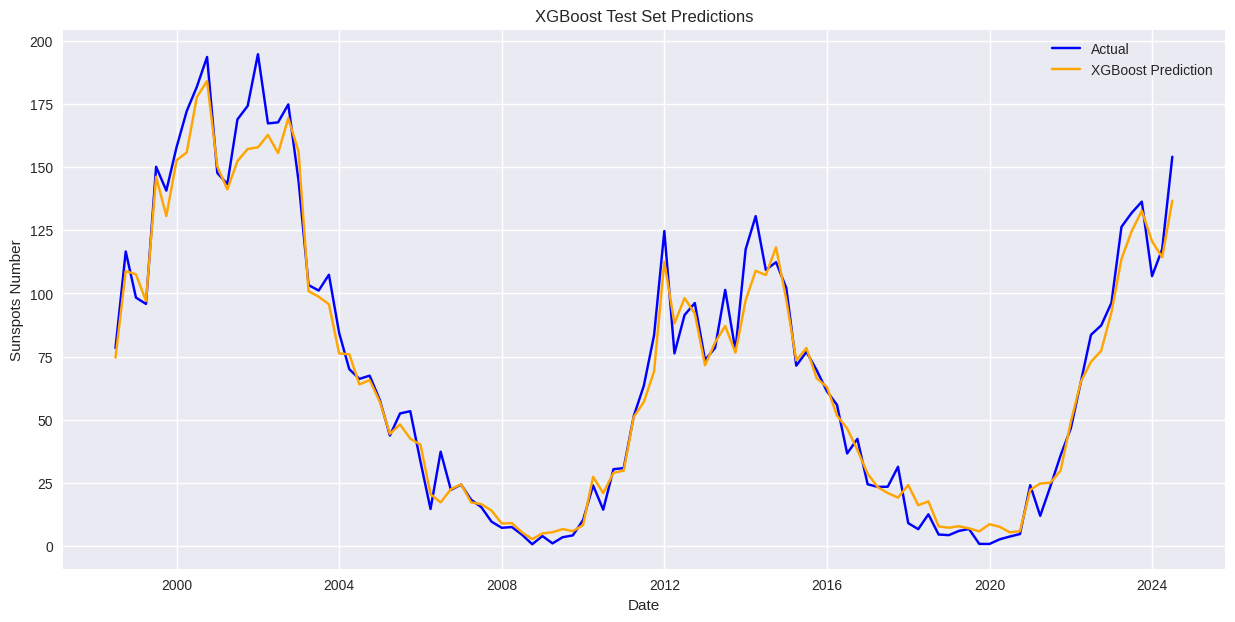

Best XGBoost Parameters:
{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

XGBoost Test Set Metrics:
MAE=6.126835350157724, MSE=73.1536669298604, RMSE=8.552991694714803, R2=0.9763386995682535

Best Model: XGBoost
Test Set Metrics for XGBoost:
MAE=6.126835350157724, MSE=73.1536669298604, RMSE=8.552991694714803, R2=0.9763386995682535


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# Assuming df is your dataframe with 'Date' and 'Sunspots_Number' columns

# Convert 'Date' to datetime and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample data to quarterly frequency
df = df.resample('Q').mean()  # Adjust as needed, e.g., 'Q' for quarterly

# Perform seasonal decomposition
result = seasonal_decompose(df['Sunspots_Number'], model='additive', period=4)  # Assuming quarterly periodicity
df['Seasonal'] = result.seasonal

# Split data into train and test sets (considering last 10% as test)
train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Feature engineering for train and test sets
def feature_engineering(data):
    data['Quarter'] = data.index.quarter
    data['Year'] = data.index.year
    data['Sin_Quarter'] = np.sin(2 * np.pi * data['Quarter'] / 4)
    data['Cos_Quarter'] = np.cos(2 * np.pi * data['Quarter'] / 4)

    # Define lagged features
    lags = [1, 2, 3, 4, 5, 6]  # lagged values for 1 quarter and 1 year (adjust as needed for quarterly data)
    for lag in lags:
        data[f'Sunspots_Number_Lag_{lag}'] = data['Sunspots_Number'].shift(lag)

    return data

# Apply feature engineering
train = feature_engineering(train)
test = feature_engineering(test)

# Compute rolling mean and rolling std only on training data
train['Rolling_Mean'] = train['Sunspots_Number'].rolling(window=4).mean()
train['Rolling_Std'] = train['Sunspots_Number'].rolling(window=4).std()

# Use rolling statistics from training set to fill test set
rolling_mean_train = train['Rolling_Mean'].dropna()
rolling_std_train = train['Rolling_Std'].dropna()

test['Rolling_Mean'] = test['Sunspots_Number'].rolling(window=4).mean()
test['Rolling_Std'] = test['Sunspots_Number'].rolling(window=4).std()

# Ensure rolling features are computed based on the training set's rolling statistics
test['Rolling_Mean'].fillna(method='ffill', inplace=True)
test['Rolling_Std'].fillna(method='ffill', inplace=True)

train.dropna(inplace=True)
test.dropna(inplace=True)

# Scaling features
scaler = StandardScaler()
X_train = train.drop(columns=['Sunspots_Number'])
y_train = train['Sunspots_Number']
X_test = test.drop(columns=['Sunspots_Number'])
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define evaluation metrics
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    return preds, mae, mse, rmse, r2

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define the parameter grid for RandomForestRegressor
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [2],
    'max_features': ['auto'],
    'bootstrap': [True]
}

# Define the parameter grid for SVR
svr_param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10, 100, 200],
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'gamma': ['scale', 'auto']
}

# Define the parameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'max_depth': [3, 5, 7]
}

# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Create scorers
scorer = make_scorer(mean_squared_error, greater_is_better=False)

### Random Forest Grid Search ###
rf_model = RandomForestRegressor(random_state=42)
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=tscv, scoring=scorer, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Best RF model
best_rf_model = rf_grid_search.best_estimator_

# Fit the best RF model on the entire training data
best_rf_model.fit(X_train, y_train)
rf_test_preds = best_rf_model.predict(X_test)

# Compute test set metrics for RF
rf_test_mae = mean_absolute_error(test['Sunspots_Number'], rf_test_preds)
rf_test_mse = mean_squared_error(test['Sunspots_Number'], rf_test_preds)
rf_test_rmse = np.sqrt(rf_test_mse)
rf_test_r2 = r2_score(test['Sunspots_Number'], rf_test_preds)
rf_test_mape = mean_absolute_percentage_error(test['Sunspots_Number'], rf_test_preds)

# Plotting the predictions
plt.figure(figsize=(15, 7))
plt.plot(test.index, test['Sunspots_Number'], label='Actual', color='blue')
plt.plot(test.index, rf_test_preds, label='Random Forest Prediction', color='green')
plt.legend()
plt.title('Random Forest Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.show()

# Print results for RF
print("Best Random Forest Parameters:")
print(rf_grid_search.best_params_)
print(f"\nRandom Forest Test Set Metrics:")
print(f"MAE={rf_test_mae}, MSE={rf_test_mse}, RMSE={rf_test_rmse}, R2={rf_test_r2}")

### SVR Grid Search ###
svr_model = SVR()
svr_grid_search = GridSearchCV(estimator=svr_model, param_grid=svr_param_grid, cv=tscv, scoring=scorer, n_jobs=-1)
svr_grid_search.fit(X_train_scaled, y_train)

# Best SVR model
best_svr_model = svr_grid_search.best_estimator_

# Fit the best SVR model on the entire training data
best_svr_model.fit(X_train_scaled, y_train)
svr_test_preds = best_svr_model.predict(X_test_scaled)

# Compute test set metrics for SVR
svr_test_mae = mean_absolute_error(test['Sunspots_Number'], svr_test_preds)
svr_test_mse = mean_squared_error(test['Sunspots_Number'], svr_test_preds)
svr_test_rmse = np.sqrt(svr_test_mse)
svr_test_r2 = r2_score(test['Sunspots_Number'], svr_test_preds)
svr_test_mape = mean_absolute_percentage_error(test['Sunspots_Number'], svr_test_preds)

# Plotting the predictions
plt.figure(figsize=(15, 7))
plt.plot(test.index, test['Sunspots_Number'], label='Actual', color='blue')
plt.plot(test.index, svr_test_preds, label='SVR Prediction', color='red')
plt.legend()
plt.title('SVR Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.show()

# Print results for SVR
print("Best SVR Parameters:")
print(svr_grid_search.best_params_)
print(f"\nSVR Test Set Metrics:")
print(f"MAE={svr_test_mae}, MSE={svr_test_mse}, RMSE={svr_test_rmse}, R2={svr_test_r2}")

### Gradient Boosting Grid Search ###
gb_model = GradientBoostingRegressor(random_state=42)
gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, cv=tscv, scoring=scorer, n_jobs=-1)
gb_grid_search.fit(X_train, y_train)

# Best GB model
best_gb_model = gb_grid_search.best_estimator_

# Fit the best GB model on the entire training data
best_gb_model.fit(X_train, y_train)
gb_test_preds = best_gb_model.predict(X_test)

# Compute test set metrics for GB
gb_test_mae = mean_absolute_error(test['Sunspots_Number'], gb_test_preds)
gb_test_mse = mean_squared_error(test['Sunspots_Number'], gb_test_preds)
gb_test_rmse = np.sqrt(gb_test_mse)
gb_test_r2 = r2_score(test['Sunspots_Number'], gb_test_preds)
gb_test_mape = mean_absolute_percentage_error(test['Sunspots_Number'], gb_test_preds)

# Plotting the predictions
plt.figure(figsize=(15, 7))
plt.plot(test.index, test['Sunspots_Number'], label='Actual', color='blue')
plt.plot(test.index, gb_test_preds, label='Gradient Boosting Prediction', color='purple')
plt.legend()
plt.title('Gradient Boosting Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.show()

# Print results for GB
print("Best Gradient Boosting Parameters:")
print(gb_grid_search.best_params_)
print(f"\nGradient Boosting Test Set Metrics:")
print(f"MAE={gb_test_mae}, MSE={gb_test_mse}, RMSE={gb_test_rmse}, R2={gb_test_r2}")

### XGBoost Grid Search ###
xgb_model = XGBRegressor(random_state=42)
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=tscv, scoring=scorer, n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

# Best XGB model
best_xgb_model = xgb_grid_search.best_estimator_

# Fit the best XGB model on the entire training data
best_xgb_model.fit(X_train, y_train)
xgb_test_preds = best_xgb_model.predict(X_test)

# Compute test set metrics for XGB
xgb_test_mae = mean_absolute_error(test['Sunspots_Number'], xgb_test_preds)
xgb_test_mse = mean_squared_error(test['Sunspots_Number'], xgb_test_preds)
xgb_test_rmse = np.sqrt(xgb_test_mse)
xgb_test_r2 = r2_score(test['Sunspots_Number'], xgb_test_preds)
xgb_test_mape = mean_absolute_percentage_error(test['Sunspots_Number'], xgb_test_preds)

# Plotting the predictions
plt.figure(figsize=(15, 7))
plt.plot(test.index, test['Sunspots_Number'], label='Actual', color='blue')
plt.plot(test.index, xgb_test_preds, label='XGBoost Prediction', color='orange')
plt.legend()
plt.title('XGBoost Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspots Number')
plt.show()

# Print results for XGB
print("Best XGBoost Parameters:")
print(xgb_grid_search.best_params_)
print(f"\nXGBoost Test Set Metrics:")
print(f"MAE={xgb_test_mae}, MSE={xgb_test_mse}, RMSE={xgb_test_rmse}, R2={xgb_test_r2}")

# Compare and print the best model's metrics
models_rmse = {
    'RandomForest': rf_test_rmse,
    'SVR': svr_test_rmse,
    'GradientBoosting': gb_test_rmse,
    'XGBoost': xgb_test_rmse
}

best_model_name = min(models_rmse, key=models_rmse.get)
print(f"\nBest Model: {best_model_name}")
print(f"Test Set Metrics for {best_model_name}:")
if best_model_name == 'RandomForest':
    print(f"MAE={rf_test_mae}, MSE={rf_test_mse}, RMSE={rf_test_rmse}, R2={rf_test_r2}")
elif best_model_name == 'SVR':
    print(f"MAE={svr_test_mae}, MSE={svr_test_mse}, RMSE={svr_test_rmse}, R2={svr_test_r2}")
elif best_model_name == 'GradientBoosting':
    print(f"MAE={gb_test_mae}, MSE={gb_test_mse}, RMSE={gb_test_rmse}, R2={gb_test_r2}")
else:
    print(f"MAE={xgb_test_mae}, MSE={xgb_test_mse}, RMSE={xgb_test_rmse}, R2={xgb_test_r2}")
